# Parkinson's Disease Motor Score Prediction - Exploratory Data Analysis

## Challenge Overview

This notebook is part of a challenge to predict the unbiased OFF motor score for Parkinson’s Disease (PD) patients. The OFF score serves as a crucial proxy for tracking neurodegeneration and disease progression, but it is often unavailable or biased due to drug effects, human subjectivity, and missing data. The goal is to develop a robust model that corrects for these biases and accurately estimates the true OFF score.

## Dataset Description

The dataset is a synthetic representation of real-world PD patient records and includes:

- Patient Demographics: Age, sex, age at diagnosis.
- Genetic Information: Relevant genetic markers.
- Medication Data: Levodopa Equivalent Daily Dosage and time since last drug intake.
- Motor Scores: ON and OFF scores, which fluctuate based on medication timing.
- Target Variable: The unbiased true OFF score, which we aim to predict.

Each patient has multiple visits recorded at irregular intervals, making time-series modeling and missing data handling essential components of this challenge.

## Approach & Methodology

1. Exploratory Data Analysis (EDA): Understanding distributions, missing data patterns, and relationships between variables.
2. Feature Engineering: Incorporating temporal effects, drug response modeling, and imputation strategies.
3. Model Selection: Evaluating regression models, time-series techniques, and ensemble methods.
4. Evaluation: Using RMSE as the primary metric to assess prediction accuracy.

## Objective

The final model should effectively:

- Adjust for the effects of levodopa to estimate the unbiased OFF score.
- Capture disease progression trends over time.
- Handle missing or irregularly collected data efficiently.

This notebook documents the end-to-end approach, from data preprocessing to model evaluation, with the aim of improving the accuracy of Parkinson’s disease severity assessments.



In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Importing dataset

In [56]:
X_train = pd.read_csv("..\\data\\X_train_6ZIKlTY.csv")
y_train = pd.read_csv("..\\data\\y_train_lXj6X5y.csv")
X_test = pd.read_csv("..\\data\\X_test_oiZ2ukx.csv")


In [57]:
X_train.head()

Index patient_id cohort  sexM    gene  age_at_diagnosis   age   ledd  \
0      0   IPLP5212      A     0  LRRK2+              48.5  52.1  607.0   
1      1   IPLP5212      A     0  LRRK2+              48.5  53.0  666.0   
2      2   IPLP5212      A     0  LRRK2+              48.5  53.9  717.0   
3      3   IPLP5212      A     0  LRRK2+              48.5  54.8  770.0   
4      4   IPLP5212      A     0  LRRK2+              48.5  56.9  885.0   

   time_since_intake_on  time_since_intake_off    on   off  
0                   1.9                    NaN   7.0   NaN  
1                   1.9                   17.6  12.0  44.0  
2                   1.2                    NaN   6.0   NaN  
3                   1.5                    NaN  11.0   NaN  
4                   0.3                    NaN  24.0   NaN

In [58]:
y_train.head()

Index  target
0      0    34.7
1      1    38.1
2      2    41.6
3      3    44.9
4      4    52.0

In [59]:
X_train.shape

(55603, 12)

In [60]:
y_train.shape

(55603, 2)

In [61]:
X_train.shape

(55603, 12)

In [62]:
missing_percentage = round(X_train.isnull().mean() * 100, 4)
print(missing_percentage)

Index                     0.0000
patient_id                0.0000
cohort                    0.0000
sexM                      0.0000
gene                     32.2968
age_at_diagnosis          5.0897
age                       0.0000
ledd                     37.0358
time_since_intake_on     46.6522
time_since_intake_off    78.8231
on                       29.9606
off                      42.0966
dtype: float64


<Axes: >

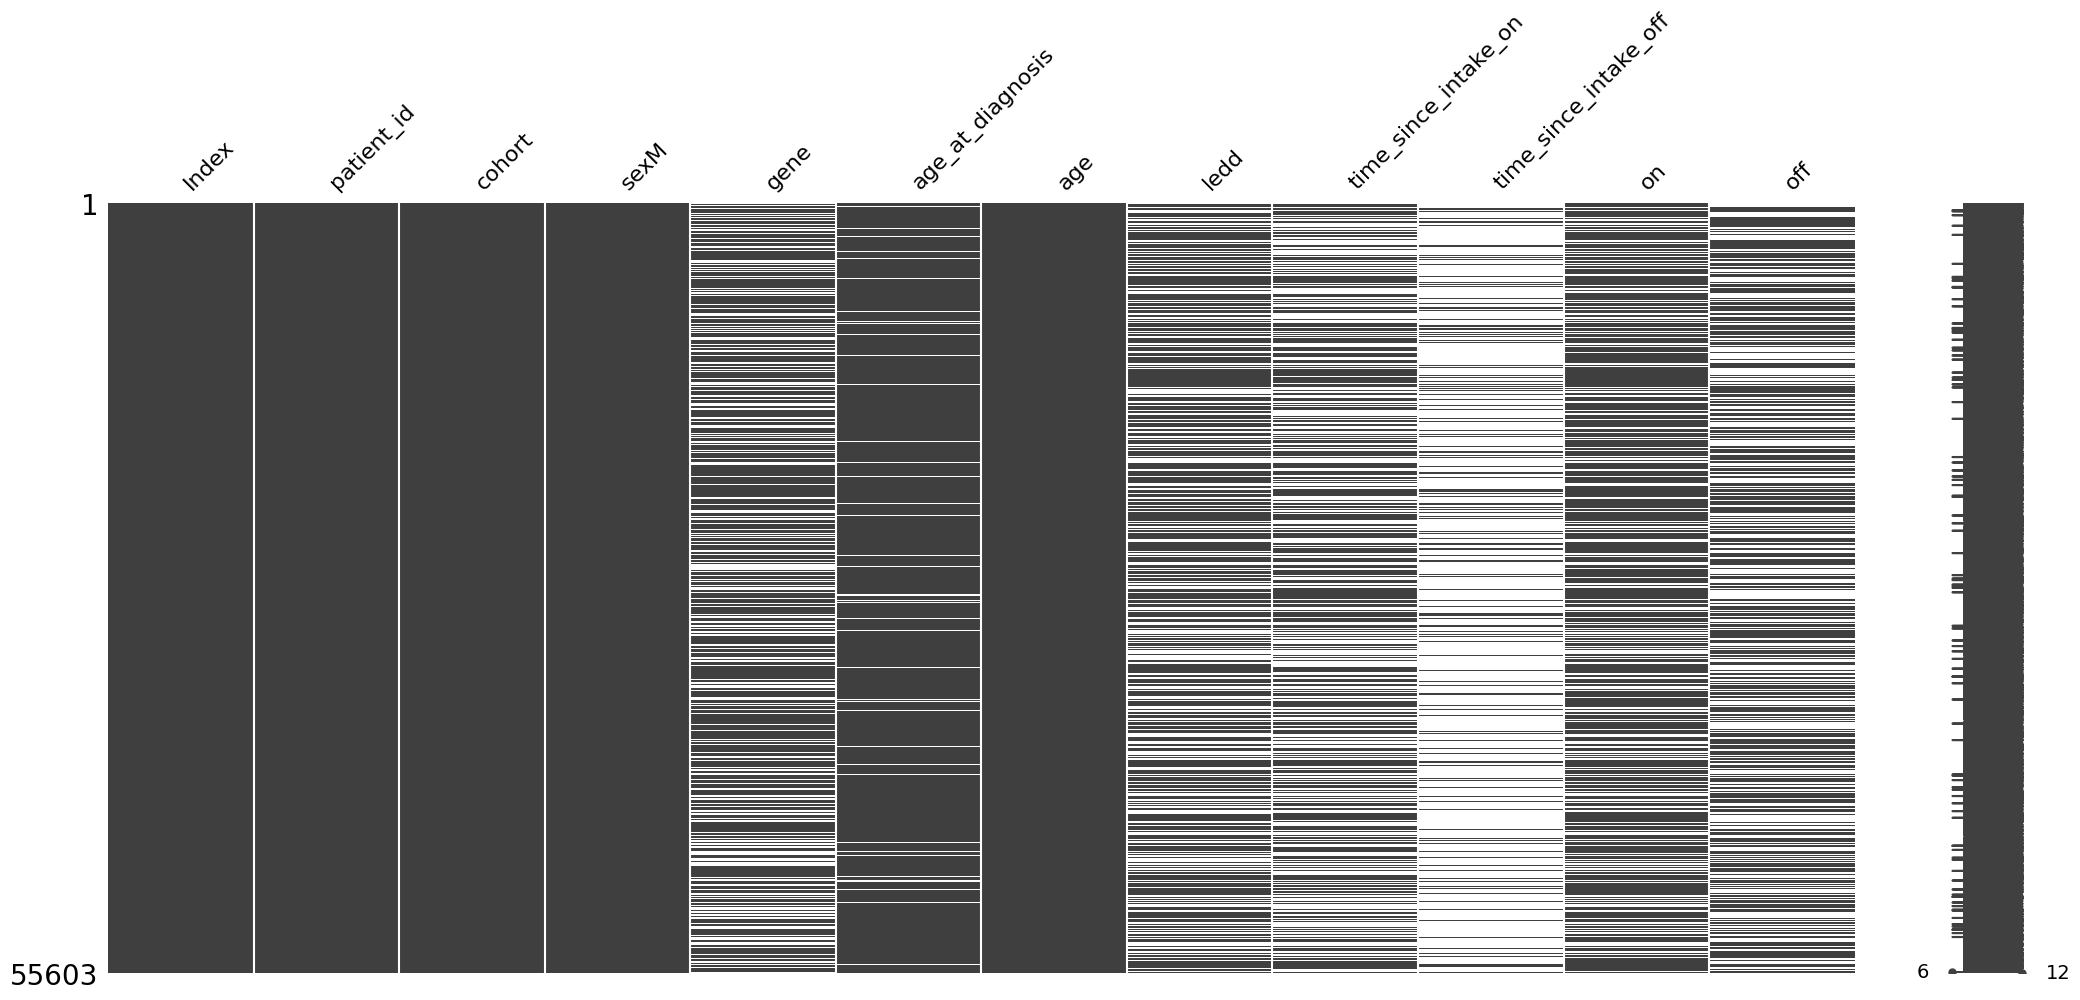

In [63]:
import missingno as msno
msno.matrix(X_train)

In [64]:
X_train.nunique()

Index                    55603
patient_id                6971
cohort                       2
sexM                         2
gene                         4
age_at_diagnosis           575
age                       1106
ledd                      1356
time_since_intake_on        64
time_since_intake_off      180
on                          80
off                         93
dtype: int64

## Age Imputation Strategy

In this task, we aim to impute the missing values in the `age_at_diagnosis` column using a method based on the patient's **minimum age** and the **average difference** between the minimum age and `age_at_diagnosis` for all patients.

### Steps for Imputation:

1. **Identify the Minimum Age**: 
   For each patient, we find their smallest recorded `age` value (e.g., the youngest age in the dataset for that patient). This is considered as the reference age.

2. **Calculate the Age Difference**: 
   We compute the difference between each patient’s `age_at_diagnosis` and the minimum recorded age for that patient. This difference represents how much the `age_at_diagnosis` deviates from the patient's minimum age.

3. **Calculate the Mean Age Difference**:
   We calculate the mean difference across all patients. This gives us a global average of how much the `age_at_diagnosis` is, on average, less than the minimum recorded age.

4. **Impute Missing Values**: 
   For any missing (`NaN`) values in the `age_at_diagnosis` column, we impute the value by subtracting the mean age difference from the patient's minimum age. The formula for imputation becomes:

   \[
   \text{{Imputed Age at Diagnosis}} = \text{{Minimum Age}} - \text{{Mean Age Difference}}
   \]

   This strategy ensures that the imputed values are consistent with the patterns observed in the data.

### Example:

Suppose for a patient, the **minimum age** is 52.5 and the **mean age difference** calculated is 2.5. The imputed `age_at_diagnosis` would be:

\[
52.5 - 2.5 = 50
\]

Thus, the missing value for `age_at_diagnosis` will be imputed with 50.

In [65]:
# Step 1: Find the smallest 'age' per patient
min_age = X_train.groupby('patient_id')['age'].transform('min')

# Step 2: Calculate the difference between the smallest 'age' and 'age_at_diagnosis' for each patient
X_train['age_diff'] = min_age - X_train['age_at_diagnosis']

# Step 3: Impute missing 'age_at_diagnosis' using the mean of the differences
mean_age_diff = X_train['age_diff'].mean()
X_train['age_at_diagnosis'] = X_train['age_at_diagnosis'].fillna(min_age - mean_age_diff)

# Final check
print(X_train[['patient_id', 'age', 'age_at_diagnosis']].head())

  patient_id   age  age_at_diagnosis
0   IPLP5212  52.1              48.5
1   IPLP5212  53.0              48.5
2   IPLP5212  53.9              48.5
3   IPLP5212  54.8              48.5
4   IPLP5212  56.9              48.5


In [66]:
X_train = X_train.drop('age_diff', axis=1)
missing_percentage = round(X_train.isnull().mean() * 100, 4)
print(missing_percentage)

Index                     0.0000
patient_id                0.0000
cohort                    0.0000
sexM                      0.0000
gene                     32.2968
age_at_diagnosis          0.0000
age                       0.0000
ledd                     37.0358
time_since_intake_on     46.6522
time_since_intake_off    78.8231
on                       29.9606
off                      42.0966
dtype: float64


### Creating time_since_diagnosis variable (which is available in the test data also)

In [67]:
X_train.insert(12, 'time_since_diagnosis', X_train["age"] - X_train["age_at_diagnosis"])

X_train.head()

Index patient_id cohort  sexM    gene  age_at_diagnosis   age   ledd  \
0      0   IPLP5212      A     0  LRRK2+              48.5  52.1  607.0   
1      1   IPLP5212      A     0  LRRK2+              48.5  53.0  666.0   
2      2   IPLP5212      A     0  LRRK2+              48.5  53.9  717.0   
3      3   IPLP5212      A     0  LRRK2+              48.5  54.8  770.0   
4      4   IPLP5212      A     0  LRRK2+              48.5  56.9  885.0   

   time_since_intake_on  time_since_intake_off    on   off  \
0                   1.9                    NaN   7.0   NaN   
1                   1.9                   17.6  12.0  44.0   
2                   1.2                    NaN   6.0   NaN   
3                   1.5                    NaN  11.0   NaN   
4                   0.3                    NaN  24.0   NaN   

   time_since_diagnosis  
0                   3.6  
1                   4.5  
2                   5.4  
3                   6.3  
4                   8.4

In [68]:
print(X_train.dtypes)

Index                      int64
patient_id                object
cohort                    object
sexM                       int64
gene                      object
age_at_diagnosis         float64
age                      float64
ledd                     float64
time_since_intake_on     float64
time_since_intake_off    float64
on                       float64
off                      float64
time_since_diagnosis     float64
dtype: object


## Understanding the missingness

<Figure size 1200x600 with 0 Axes>

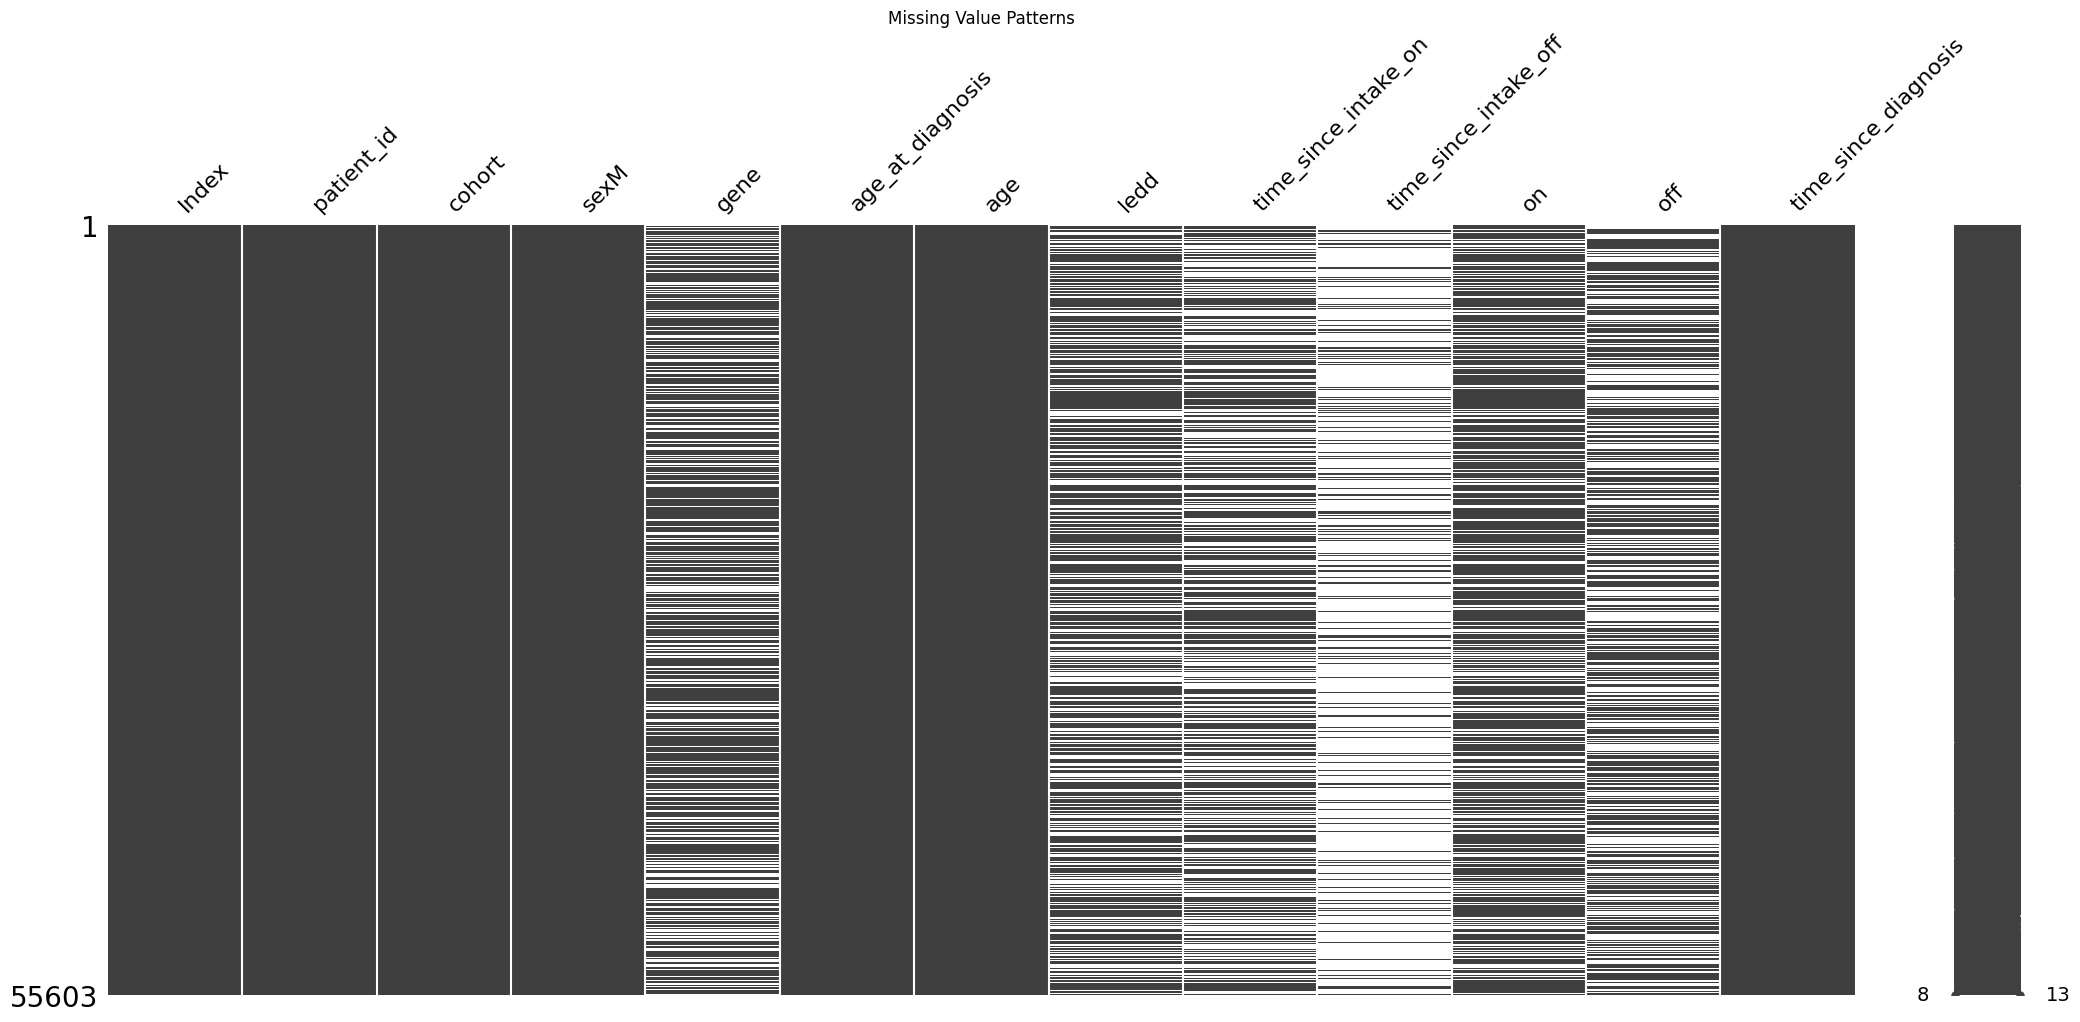

<Figure size 1000x800 with 0 Axes>

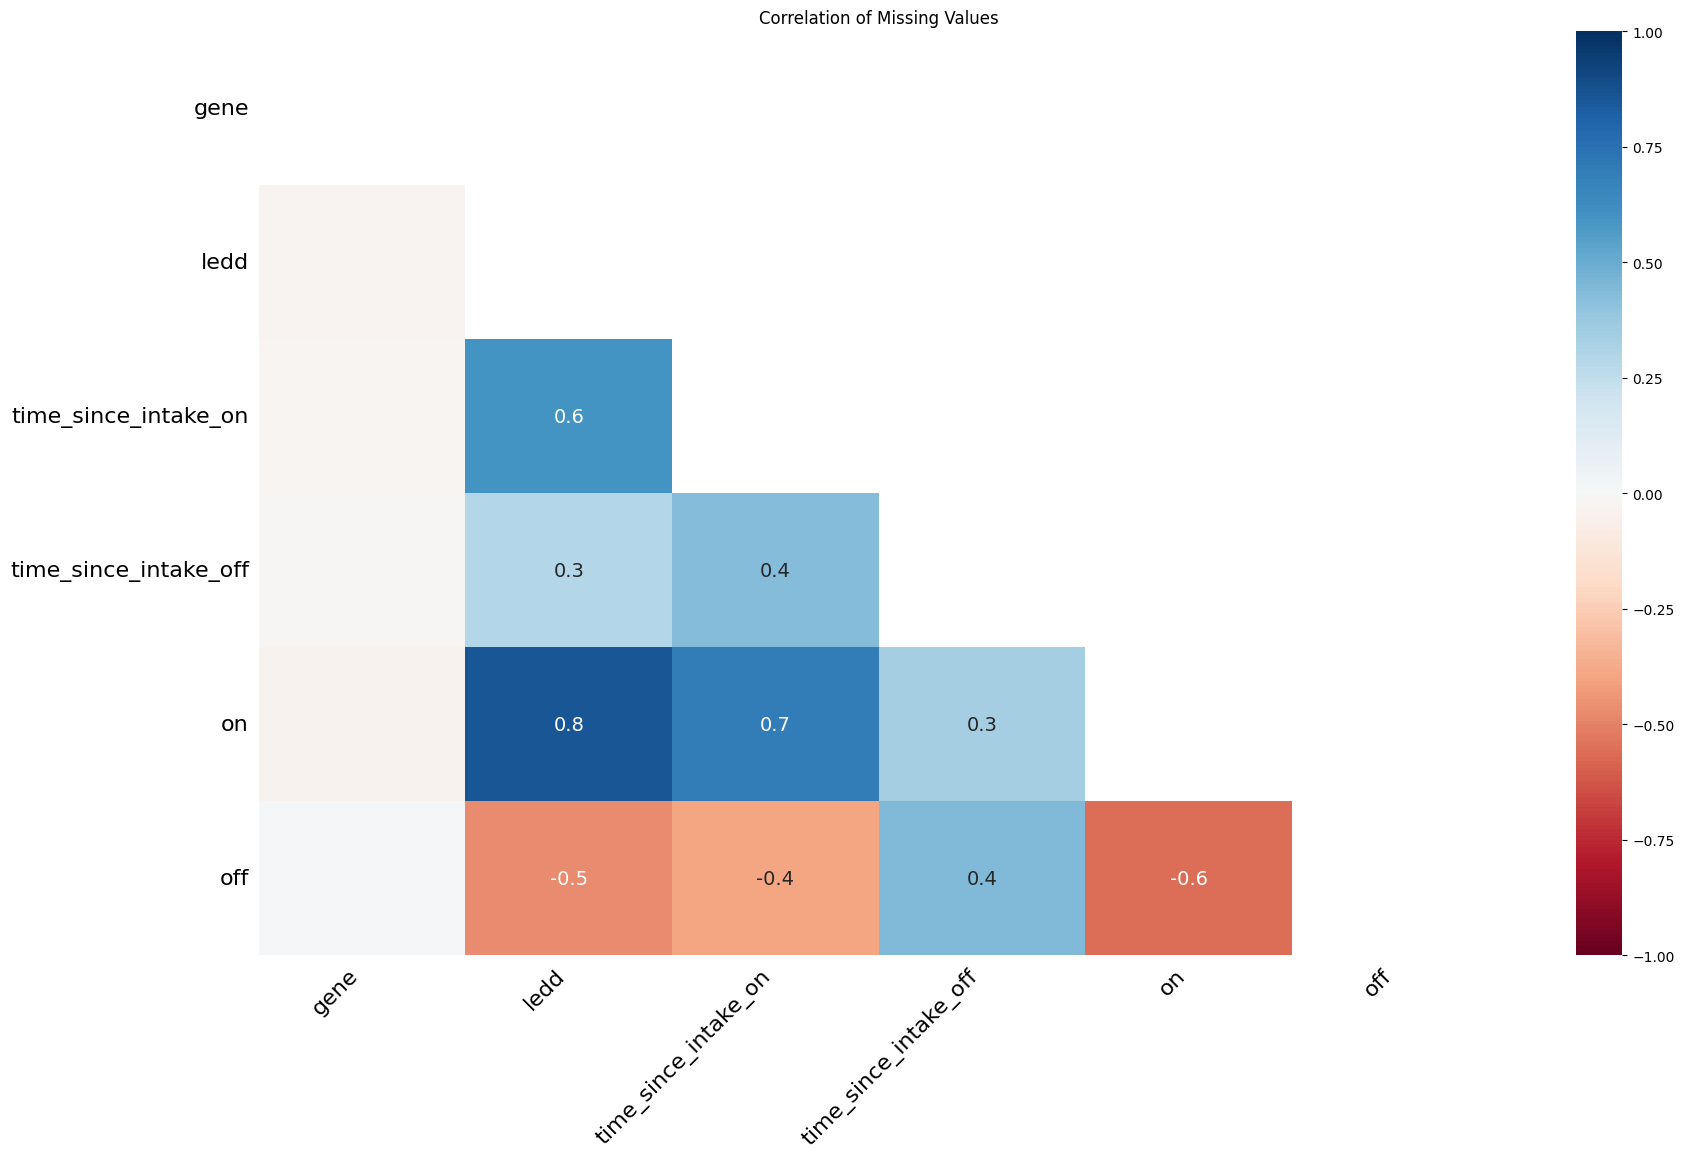

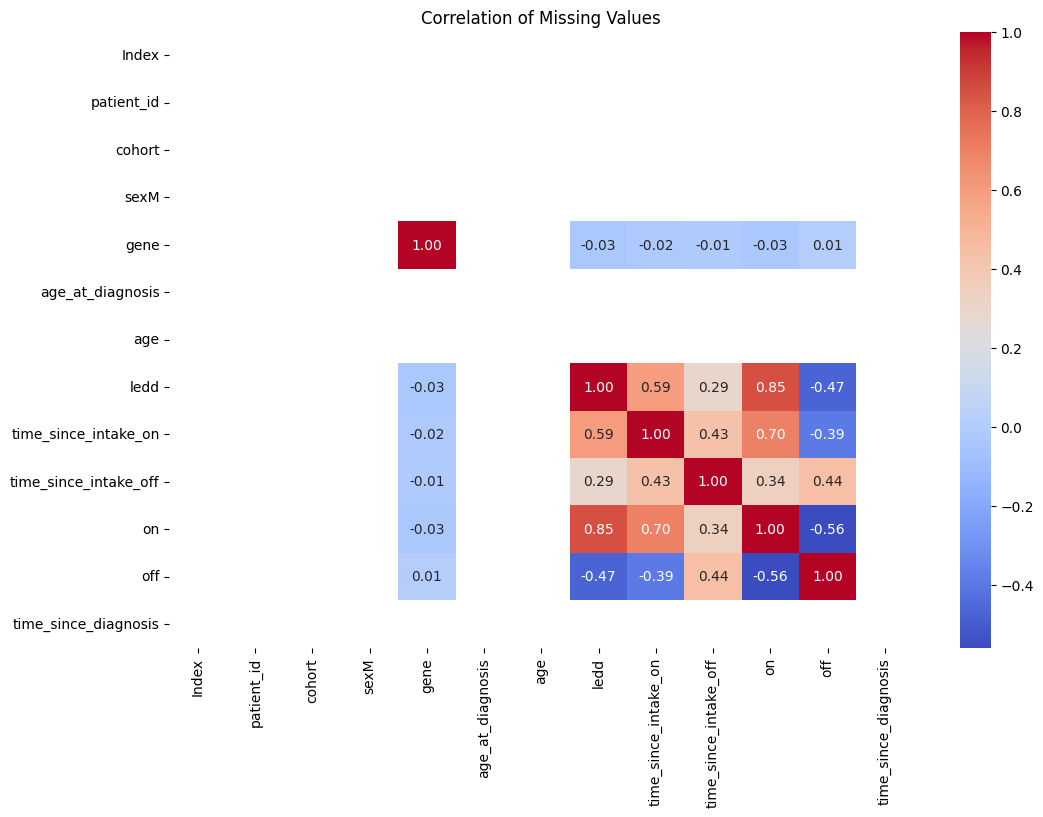


Most common missing value patterns:
0000000111100    11675
0000000001010    10764
0000000000000     6684
0000100001010     5234
0000100111100     4984
Name: count, dtype: int64

Total number of unique patterns: 26

Missing value statistics per patient:
        Index  patient_id  cohort    sexM         gene  age_at_diagnosis  \
count  6971.0      6971.0  6971.0  6971.0  6971.000000            6971.0   
mean      0.0         0.0     0.0     0.0     2.576101               0.0   
std       0.0         0.0     0.0     0.0     4.171028               0.0   
min       0.0         0.0     0.0     0.0     0.000000               0.0   
25%       0.0         0.0     0.0     0.0     0.000000               0.0   
50%       0.0         0.0     0.0     0.0     0.000000               0.0   
75%       0.0         0.0     0.0     0.0     4.000000               0.0   
max       0.0         0.0     0.0     0.0    12.000000               0.0   

          age         ledd  time_since_intake_on  time_since_

In [69]:
import missingno as msno
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 1. Missingno visualizations 
plt.figure(figsize=(12, 6))
msno.matrix(X_train)
plt.title("Missing Value Patterns")
plt.show()

plt.figure(figsize=(10, 8))
msno.heatmap(X_train)
plt.title("Correlation of Missing Values")
plt.show()

# 2. Missing value correlation analysis
missing_matrix = X_train.isnull().astype(int)
correlation_matrix = missing_matrix.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation of Missing Values')
plt.show()

# 3. Pattern analysis
# Convert missing value patterns to binary string
patterns = X_train.isnull().astype(int).astype(str).apply(''.join, axis=1)
pattern_counts = patterns.value_counts()

print("\nMost common missing value patterns:")
print(pattern_counts.head())
print(f"\nTotal number of unique patterns: {len(pattern_counts)}")

# 4. Patient-based pattern analysis
if 'patient_id' in X_train.columns:
   missing_by_patient = X_train.groupby('patient_id').apply(lambda x: x.isnull().sum())
   print("\nMissing value statistics per patient:")
   print(missing_by_patient.describe())

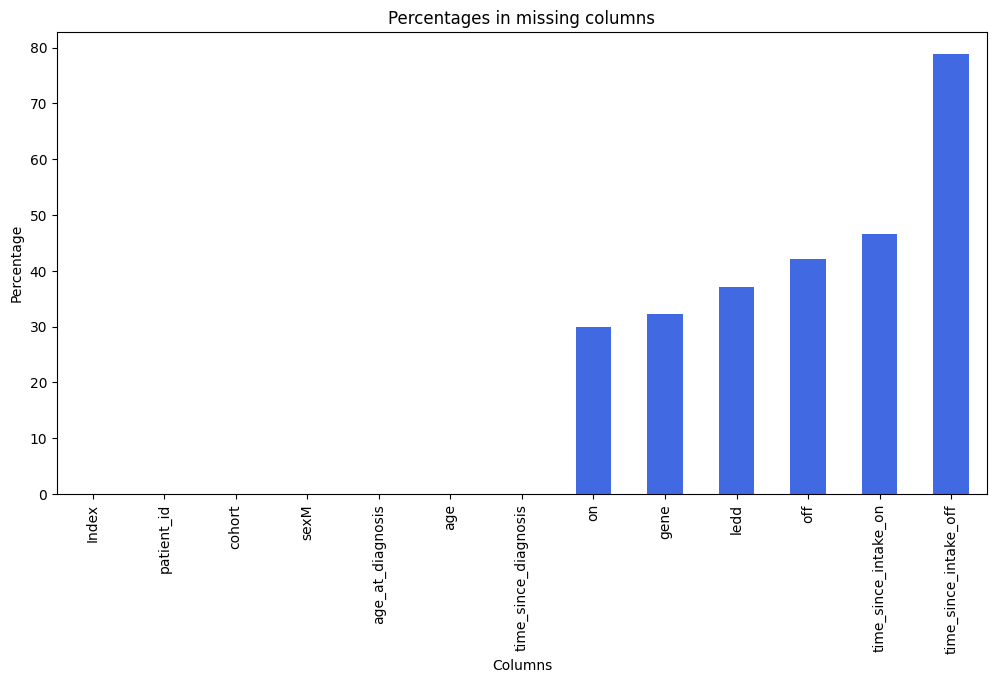

In [70]:
missing_percentage = round(X_train.isnull().mean() * 100, 4)

plt.figure(figsize=(12, 6))
missing_percentage.sort_values().plot(kind="bar", color="royalblue")
plt.title("Percentages in missing columns")
plt.ylabel("Percentage")
plt.xlabel("Columns")
plt.xticks(rotation=90)
plt.show()

# Advanced Imputation Strategy for Parkinson's Disease Dataset

## Missing Value Analysis

First, I analyzed the missing value patterns in our dataset. As shown in earlier visualizations, several columns had significant missing percentages:

```
time_since_intake_off    ~80%
time_since_intake_on     ~47% 
off                      ~42%
ledd                     ~37%
on                       ~30%
```

The missing values weren't randomly distributed - they showed specific patterns:

```
Most common missing patterns:
00000001111000    11675
00000000010100    10764
00000000000000     6684
00001000010100     5234
00001001111000     4984
```

## Correlation in Missing Data

The correlation heatmap revealed important relationships between missing values:
- Strong positive correlation (0.85) between missing values in `ledd` and `on`
- Strong positive correlation (0.70) between `time_since_intake_on` and `on`
- Negative correlation (-0.56) between `on` and `off`

These patterns suggested that missingness was MAR (Missing At Random) rather than MCAR (Missing Completely At Random).

## Imputation Strategy

### 1. Cross-filling Gene Values

Since genetic information should be consistent for each patient, I implemented cross-dataset filling:

```python
def cross_fill_gene_values(train_df, test_df):
    """
    Fill missing gene values in train set using values from test set
    and vice versa for the same patient
    """
    # For each patient, check both datasets
    # If gene info exists in one but not the other, transfer it
```

This step utilizes the fact that records from the same patient appear in both train and test sets.

### 2. Feature Type Detection

I automatically detected categorical vs numerical features:

```python
categorical_cols, numerical_cols = check_data_types(X_train)
```

### 3. Group-Based Imputation

Based on correlation analysis, I divided features into groups:

#### Group 1: Highly Correlated Features
- `ledd`, `on`, `time_since_intake_on`
- **Method**: MICE (Multiple Imputation by Chained Equations)
- **Why**: Preserves relationships between highly correlated variables

```python
mice_imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100),
    max_iter=10,
    random_state=42
)
```

#### Group 2: Moderately Correlated Features
- `time_since_intake_off`, `off`
- **Method**: Random Forest Imputation
- **Why**: Captures non-linear relationships

#### Group 3: Patient-Specific Categorical Features
- `gene` (if categorical)
- **Method**: Patient-specific mode, with KNN as backup
- **Why**: Maintains patient-specific information

### 4. Validation with Cross-Validation

For each imputation method, I validated quality using k-fold cross-validation:
- Artificially masked known values
- Applied imputation strategies
- Calculated RMSE and R² to measure imputation accuracy

### 5. Distribution Verification

I compared distributions before and after imputation:
- Blue: Original non-null distribution
- Red: Imputed values only
- Green: Final distribution after imputation

As seen in the plots, the imputation preserved the general distribution characteristics while filling all missing values.

## Results

The imputation successfully filled all missing values with reasonable distributions:

```
Remaining null values in training set:
Index                    0
patient_id               0
...
time_since_diagnosis     0
dtype: int64

Remaining null values in test set:
Index                    0
patient_id               0
...
time_since_diagnosis     0
dtype: int64
```

## Why This Approach Works for Parkinson's Data

1. **Patient-Specific**: Leverages consistency within patient records
2. **Preserves Relationships**: Maintains correlations between clinical measurements
3. **Prevents Data Leakage**: Keeps train/test separation while using all available information
4. **Respects Variable Types**: Handles categorical and numerical features appropriately
5. **Evidence-Based**: Methods chosen based on actual missing patterns

This approach is particularly suited for Parkinson's disease data where patient-specific patterns are important and clinical measurements have meaningful relationships that should be preserved during imputation.

Before cross-filling:
Missing gene values in train: 17958
Missing gene values in test: 7763

After cross-filling:
Filled 0 missing gene values in train set
Filled 0 missing gene values in test set
Remaining missing gene values in train: 17958
Remaining missing gene values in test: 7763
Column data types:
Index                      int64
patient_id                object
cohort                    object
sexM                       int64
gene                      object
age_at_diagnosis         float64
age                      float64
ledd                     float64
time_since_intake_on     float64
time_since_intake_off    float64
on                       float64
off                      float64
time_since_diagnosis     float64
dtype: object


C:\Users\cilek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cilek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cilek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cilek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [Itera

Validation results for MICE for Group 1:
ledd: RMSE=228.2075, R²=-0.0818
on: RMSE=10.2146, R²=0.0295
time_since_intake_on: RMSE=1.4349, R²=-0.5269


C:\Users\cilek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Validation results for Random Forest for Group 2:
time_since_intake_off: RMSE=2.8525, R²=-0.0070
off: RMSE=17.4690, R²=-0.1165


C:\Users\cilek\AppData\Local\Temp\ipykernel_60368\4250257568.py:401: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(imputed_df.loc[mask, col], label=f'Imputed values only', color='red')
C:\Users\cilek\AppData\Local\Temp\ipykernel_60368\4250257568.py:401: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(imputed_df.loc[mask, col], label=f'Imputed values only', color='red')


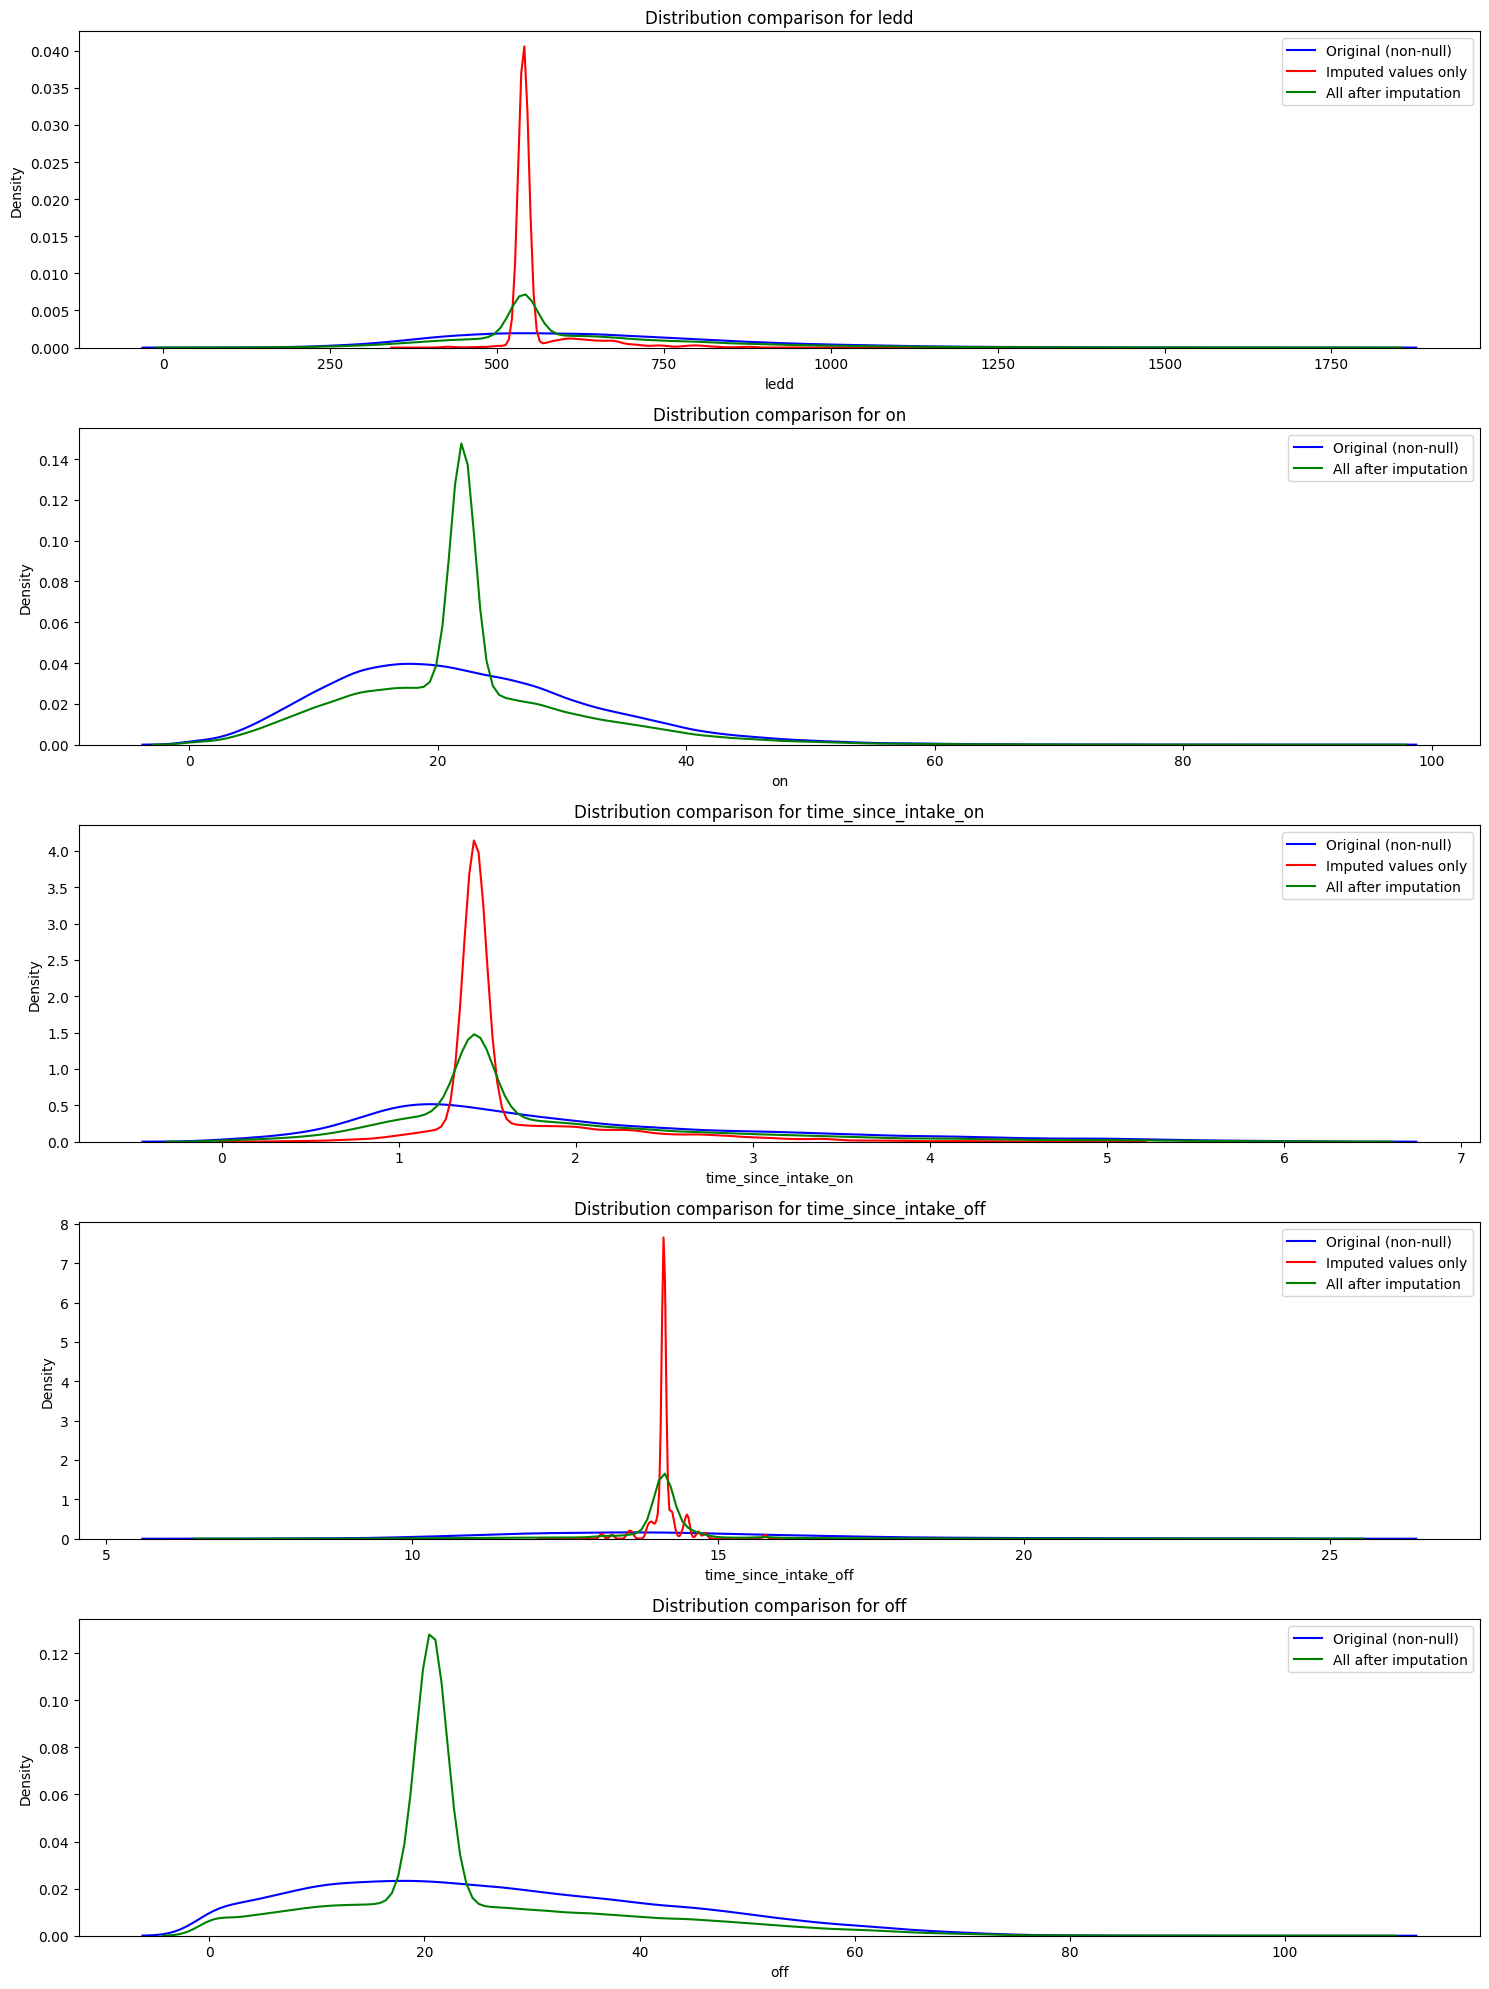

Remaining null values in training set:
Index                    0
patient_id               0
cohort                   0
sexM                     0
gene                     0
age_at_diagnosis         0
age                      0
ledd                     0
time_since_intake_on     0
time_since_intake_off    0
on                       0
off                      0
time_since_diagnosis     0
dtype: int64

Remaining null values in test set:
Index                    0
patient_id               0
cohort                   0
sexM                     0
gene                     0
age_at_diagnosis         0
age                      0
ledd                     0
time_since_intake_on     0
time_since_intake_off    0
on                       0
off                      0
time_since_diagnosis     0
dtype: int64

Imputation pipeline complete!


In [71]:
# Comprehensive Imputation Strategy for Parkinson's Dataset
# Based on correlation analysis and missing value patterns

import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Function to fill missing gene values from other set (train→test or test→train)
def cross_fill_gene_values(train_df, test_df):
    """
    Fill missing gene values in train set using values from test set
    and vice versa for the same patient
    """
    print("Before cross-filling:")
    print(f"Missing gene values in train: {train_df['gene'].isna().sum()}")
    print(f"Missing gene values in test: {test_df['gene'].isna().sum()}")
    
    # Create copies to avoid modifying originals
    train_filled = train_df.copy()
    test_filled = test_df.copy()
    
    # Get unique patient IDs
    all_patients = set(train_df['patient_id'].unique()) | set(test_df['patient_id'].unique())
    filled_count_train = 0
    filled_count_test = 0
    
    for patient_id in all_patients:
        # Check if patient exists in both datasets
        in_train = patient_id in train_df['patient_id'].values
        in_test = patient_id in test_df['patient_id'].values
        
        if in_train and in_test:
            # Get gene values for this patient from both sets
            train_genes = train_df[train_df['patient_id'] == patient_id]['gene'].dropna().unique()
            test_genes = test_df[test_df['patient_id'] == patient_id]['gene'].dropna().unique()
            
            # If train has missing values but test has values
            if train_df[train_df['patient_id'] == patient_id]['gene'].isna().any() and len(test_genes) > 0:
                # Use most common gene value from test
                if len(test_genes) == 1:
                    gene_value = test_genes[0]
                else:
                    # If multiple values, take most frequent
                    gene_counts = test_df[test_df['patient_id'] == patient_id]['gene'].value_counts()
                    gene_value = gene_counts.index[0]
                
                # Fill missing values in train
                missing_mask = (train_filled['patient_id'] == patient_id) & (train_filled['gene'].isna())
                train_filled.loc[missing_mask, 'gene'] = gene_value
                filled_count_train += missing_mask.sum()
            
            # If test has missing values but train has values
            if test_df[test_df['patient_id'] == patient_id]['gene'].isna().any() and len(train_genes) > 0:
                # Use most common gene value from train
                if len(train_genes) == 1:
                    gene_value = train_genes[0]
                else:
                    # If multiple values, take most frequent
                    gene_counts = train_df[train_df['patient_id'] == patient_id]['gene'].value_counts()
                    gene_value = gene_counts.index[0]
                
                # Fill missing values in test
                missing_mask = (test_filled['patient_id'] == patient_id) & (test_filled['gene'].isna())
                test_filled.loc[missing_mask, 'gene'] = gene_value
                filled_count_test += missing_mask.sum()
    
    print("\nAfter cross-filling:")
    print(f"Filled {filled_count_train} missing gene values in train set")
    print(f"Filled {filled_count_test} missing gene values in test set")
    print(f"Remaining missing gene values in train: {train_filled['gene'].isna().sum()}")
    print(f"Remaining missing gene values in test: {test_filled['gene'].isna().sum()}")
    
    return train_filled, test_filled


X_train_cross_filled, X_test_cross_filled = cross_fill_gene_values(X_train, X_test)

X_train_imputed = X_train_cross_filled.copy()
X_test_imputed = X_test_cross_filled.copy()

# 2. First let's check column types to identify categorical vs numerical features
def check_data_types(df):
    """Check data types and identify categorical and numerical columns"""
    dtypes = df.dtypes
    print("Column data types:")
    print(dtypes)
    
    # Check for columns that appear numeric but contain strings
    for col in df.columns:
        # Skip columns that are already identified as object type
        if df[col].dtype == 'object':
            continue
            
        # Check for strings in numeric columns
        try:
            # Try to calculate mean - will fail if strings are present
            df[col].mean()
        except TypeError:
            print(f"Warning: Column '{col}' appears to contain string values")
            # Show a sample of the column
            print(f"Sample values: {df[col].sample(5).values}")
    
    # Categorize columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    
    return categorical_cols, numerical_cols

# Check data types
categorical_cols, numerical_cols = check_data_types(X_train)


# 3. Get patient statistics for numerical columns only
def get_patient_stats(df, numerical_cols):
    """Calculate statistics for each patient to use in imputation"""
    # Create aggregation dictionary for numerical columns only
    agg_dict = {}
    for col in numerical_cols:
        if col != 'patient_id' and col in df.columns:
            agg_dict[col] = ['mean', 'median', 'std']
    
    # Skip if no numerical columns to aggregate
    if not agg_dict:
        print("No numerical columns available for aggregation")
        return pd.DataFrame()
    
    # Perform groupby aggregation
    patient_stats = df.groupby('patient_id').agg(agg_dict)
    
    # Flatten multi-index columns
    patient_stats.columns = ['_'.join(col).strip() for col in patient_stats.columns.values]
    
    return patient_stats

# Get patient statistics for numerical columns
patient_stats = get_patient_stats(X_train, numerical_cols)

# 4. Handle categorical columns separately
def handle_categorical_features(df_train, df_test, categorical_cols):
    """Process categorical features with appropriate methods"""
    train_imputed = df_train.copy()
    test_imputed = df_test.copy()
    
    for col in categorical_cols:
        if col == 'patient_id' or col == 'cohort' or col == 'index':
            # Skip identifier columns
            continue
            
        # Get mode (most frequent value) by patient where possible
        if 'patient_id' in df_train.columns:
            # Get most frequent value for each patient
            patient_modes = df_train.groupby('patient_id')[col].agg(
                lambda x: x.mode()[0] if not x.mode().empty else None
            )
            
            # Fill missing values with patient-specific mode
            for patient_id, mode_value in patient_modes.items():
                if mode_value is not None:
                    # Fill missing values for this patient in train set
                    mask = (df_train['patient_id'] == patient_id) & (df_train[col].isna())
                    train_imputed.loc[mask, col] = mode_value
                    
                    # Fill missing values for this patient in test set
                    if patient_id in df_test['patient_id'].values:
                        mask = (df_test['patient_id'] == patient_id) & (df_test[col].isna())
                        test_imputed.loc[mask, col] = mode_value
        
        # For any remaining missing values, use global mode
        if train_imputed[col].isna().any() or test_imputed[col].isna().any():
            global_mode = df_train[col].mode()[0] if not df_train[col].mode().empty else None
            if global_mode is not None:
                train_imputed[col] = train_imputed[col].fillna(global_mode)
                test_imputed[col] = test_imputed[col].fillna(global_mode)
    
    return train_imputed, test_imputed

# Process categorical columns
if categorical_cols:
    X_train_imputed, X_test_imputed = handle_categorical_features(
        X_train, X_test, categorical_cols
    )

# 5. Define validation function for numerical columns
def validate_imputation(original_df, strategy_name, imputer, columns, k=5):
    """
    Perform k-fold cross-validation to evaluate imputation strategy
    Returns RMSE and R² for artificially masked values
    """
    # Skip validation if no columns to validate
    if not columns:
        print(f"No columns available for {strategy_name} validation")
        return {}
        
    results = {col: {'rmse': [], 'r2': []} for col in columns}
    
    # Create k-fold cross-validator
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(original_df):
        train_fold = original_df.iloc[train_idx].copy()
        val_fold = original_df.iloc[val_idx].copy()
        
        # For each column to validate
        for col in columns:
            # Get non-null values in validation fold
            mask = val_fold[col].notna()
            if not mask.any():
                continue
                
            # Store original values and then mask them
            true_values = val_fold.loc[mask, col].copy()
            val_fold.loc[mask, col] = np.nan
            
            # Combine datasets for imputation (with masked values)
            combined = pd.concat([train_fold, val_fold])
            
            # Fit imputer on combined data
            imputed_values = imputer.fit_transform(combined[columns])
            imputed_combined = pd.DataFrame(imputed_values, 
                                           index=combined.index,
                                           columns=columns)
            
            # Extract predictions for the masked values
            predictions = imputed_combined.loc[val_fold[mask].index, col]
            
            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(true_values, predictions))
            r2 = r2_score(true_values, predictions)
            
            # Store results
            results[col]['rmse'].append(rmse)
            results[col]['r2'].append(r2)
    
    # Average results across folds
    summary = {col: {
        'avg_rmse': np.mean(metrics['rmse']),
        'avg_r2': np.mean(metrics['r2'])
    } for col, metrics in results.items()}
    
    print(f"Validation results for {strategy_name}:")
    for col, metrics in summary.items():
        print(f"{col}: RMSE={metrics['avg_rmse']:.4f}, R²={metrics['avg_r2']:.4f}")
    
    return summary

# 6. Identify columns for each imputation group
# Using only numerical columns for these imputation methods
numerical_cols = [col for col in numerical_cols if col != 'patient_id' and col != 'index']

# Group 1: ledd, on, time_since_intake_on (if they're numerical)
group1_cols = [col for col in ['ledd', 'on', 'time_since_intake_on'] 
               if col in numerical_cols]

# Group 2: time_since_intake_off, off (if they're numerical)
group2_cols = [col for col in ['time_since_intake_off', 'off'] 
               if col in numerical_cols]

# Group 3: gene (only if it's numerical)
group3_cols = ['gene'] if 'gene' in numerical_cols else []

# 7. Group 1 imputation (highly correlated): Using MICE
if group1_cols:
    # Create MICE imputer
    mice_imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=100, random_state=42),
        max_iter=10,
        random_state=42,
        verbose=0
    )
    
    # Validate MICE imputation strategy
    mice_validation = validate_imputation(
        X_train_imputed, 
        "MICE for Group 1", 
        mice_imputer, 
        group1_cols
    )
    
    # Apply to train data
    X_train_imputed[group1_cols] = mice_imputer.fit_transform(X_train_imputed[group1_cols])
    
    # Apply to test data using the same fitted imputer
    X_test_imputed[group1_cols] = mice_imputer.transform(X_test_imputed[group1_cols])

# 8. Group 2 imputation (moderately correlated): Using Random Forest
if group2_cols:
    class RFImputer:
        """Custom RF imputer class to make validation consistent"""
        def __init__(self, n_estimators=100, random_state=42):
            self.n_estimators = n_estimators
            self.random_state = random_state
            self.models = {}
            
        def fit_transform(self, X):
            """Fit RF models and transform data"""
            result = X.copy()
            
            for col in X.columns:
                # Skip if no missing values
                if not X[col].isna().any():
                    continue
                    
                # Prepare train data (non-missing values)
                train_data = X[X[col].notna()]
                features = [c for c in X.columns if c != col]
                
                # Train RF model
                rf = RandomForestRegressor(
                    n_estimators=self.n_estimators,
                    random_state=self.random_state
                )
                rf.fit(train_data[features], train_data[col])
                self.models[col] = rf
                
                # Predict missing values
                missing_idx = X[X[col].isna()].index
                if len(missing_idx) > 0:
                    result.loc[missing_idx, col] = rf.predict(X.loc[missing_idx, features])
                    
            return result
        
        def transform(self, X):
            """Transform only using fitted models"""
            result = X.copy()
            
            for col, model in self.models.items():
                # Skip if no missing values or no model
                if not X[col].isna().any() or col not in self.models:
                    continue
                    
                # Predict missing values
                features = [c for c in X.columns if c != col]
                missing_idx = X[X[col].isna()].index
                if len(missing_idx) > 0:
                    result.loc[missing_idx, col] = model.predict(X.loc[missing_idx, features])
                    
            return result
    
    # Create RF imputer
    rf_imputer = RFImputer()
    
    # Validate RF imputation strategy
    rf_validation = validate_imputation(
        X_train_imputed,
        "Random Forest for Group 2",
        rf_imputer,
        group2_cols
    )
    
    # Apply to train data
    X_train_imputed[group2_cols] = rf_imputer.fit_transform(X_train_imputed[group2_cols])
    
    # Apply to test data
    X_test_imputed[group2_cols] = rf_imputer.transform(X_test_imputed[group2_cols])

# 9. Group 3 imputation (gene column): Using KNN o
if group3_cols:
    # Create KNN imputer
    knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
    
    # Validate KNN imputation strategy
    knn_validation = validate_imputation(
        X_train_imputed,
        "KNN for Gene imputation",
        knn_imputer,
        group3_cols
    )
    
    # Apply to train data
    X_train_imputed[group3_cols] = knn_imputer.fit_transform(X_train_imputed[group3_cols])
    
    # Apply to test data
    X_test_imputed[group3_cols] = knn_imputer.transform(X_test_imputed[group3_cols])

# 10. Verify imputation quality - Check distributions before/after
def plot_imputation_distributions(original_df, imputed_df, columns):
    """Plot density distributions before and after imputation"""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    if not columns:
        print("No columns available for distribution plotting")
        return
    
    plt.figure(figsize=(15, len(columns)*4))
    
    for i, col in enumerate(columns):
        plt.subplot(len(columns), 1, i+1)
        
        # Original non-null distribution
        sns.kdeplot(original_df[col].dropna(), label=f'Original (non-null)', color='blue')
        
        # Imputed values only
        mask = original_df[col].isna()
        if mask.sum() > 0:
            sns.kdeplot(imputed_df.loc[mask, col], label=f'Imputed values only', color='red')
        
        # All values after imputation
        sns.kdeplot(imputed_df[col], label=f'All after imputation', color='green')
        
        plt.title(f'Distribution comparison for {col}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot distributions for all imputed numerical columns
all_imputed_numerical_cols = group1_cols + group2_cols + group3_cols
plot_imputation_distributions(X_train, X_train_imputed, all_imputed_numerical_cols)

# 11. Final verification: Check for any remaining missing values
remaining_nulls = X_train_imputed.isnull().sum()
print("Remaining null values in training set:")
print(remaining_nulls)

remaining_nulls_test = X_test_imputed.isnull().sum() 
print("\nRemaining null values in test set:")
print(remaining_nulls_test)

print("\nImputation pipeline complete!")

In [75]:
X_train_imputed.head()

Index patient_id cohort  sexM    gene  age_at_diagnosis   age   ledd  \
0      0   IPLP5212      A     0  LRRK2+              48.5  52.1  607.0   
1      1   IPLP5212      A     0  LRRK2+              48.5  53.0  666.0   
2      2   IPLP5212      A     0  LRRK2+              48.5  53.9  717.0   
3      3   IPLP5212      A     0  LRRK2+              48.5  54.8  770.0   
4      4   IPLP5212      A     0  LRRK2+              48.5  56.9  885.0   

   time_since_intake_on  time_since_intake_off    on        off  \
0                   1.9              14.111042   7.0  20.656235   
1                   1.9              17.600000  12.0  44.000000   
2                   1.2              14.111042   6.0  20.656235   
3                   1.5              14.111042  11.0  20.656235   
4                   0.3              14.111042  24.0  20.656235   

   time_since_diagnosis  
0                   3.6  
1                   4.5  
2                   5.4  
3                   6.3  
4                   8.4

# Data Visualization and Analysis

In [76]:
X_train_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55603 entries, 0 to 55602
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Index                  55603 non-null  int64  
 1   patient_id             55603 non-null  object 
 2   cohort                 55603 non-null  object 
 3   sexM                   55603 non-null  int64  
 4   gene                   55603 non-null  object 
 5   age_at_diagnosis       55603 non-null  float64
 6   age                    55603 non-null  float64
 7   ledd                   55603 non-null  float64
 8   time_since_intake_on   55603 non-null  float64
 9   time_since_intake_off  55603 non-null  float64
 10  on                     55603 non-null  float64
 11  off                    55603 non-null  float64
 12  time_since_diagnosis   55603 non-null  float64
dtypes: float64(8), int64(2), object(3)
memory usage: 5.5+ MB


In [77]:
X_train_imputed.describe()

Index          sexM  age_at_diagnosis           age  \
count  55603.000000  55603.000000      55603.000000  55603.000000   
mean   27801.000000      0.596353         56.685782     62.516422   
std    16051.347846      0.490633         10.819436     11.484480   
min        0.000000      0.000000         16.500000     16.500000   
25%    13900.500000      0.000000         49.300000     54.900000   
50%    27801.000000      1.000000         56.800000     62.500000   
75%    41701.500000      1.000000         64.300000     70.500000   
max    55602.000000      1.000000         89.900000    103.300000   

               ledd  time_since_intake_on  time_since_intake_off  \
count  55603.000000          55603.000000           55603.000000   
mean     609.078155              1.799082              14.145028   
std      181.654286              0.932231               1.331945   
min       50.000000              0.000000               6.900000   
25%      539.850000              1.400000              14.082113   
50%      539.850000              1.430867              14.111042   
75%      683.000000              2.100000              14.151703   
max     1796.000000              6.300000              25.100000   

                 on           off  time_since_diagnosis  
count  55603.000000  55603.000000          55603.000000  
mean      21.990180     23.921452              5.830640  
std        8.679655     12.886129              3.854157  
min        0.000000      0.000000              0.000000  
25%       17.000000     20.656235              2.700000  
50%       22.000000     20.656235              5.300000  
75%       25.000000     27.000000              8.400000  
max       95.000000    106.000000             24.700000

In [78]:
numeric_features = [feature for feature in X_train_imputed.columns if X_train_imputed[feature].dtype != 'O']
categorical_features = [feature for feature in X_train_imputed.columns if X_train_imputed[feature].dtype == 'O']

## For analysis, I create a new column named sex which represents sexM column as a male or female
X_train_imputed["sex"] = X_train_imputed["sexM"].map({1: "Male", 0: "Female"})

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))



We have 10 numerical features : ['Index', 'sexM', 'age_at_diagnosis', 'age', 'ledd', 'time_since_intake_on', 'time_since_intake_off', 'on', 'off', 'time_since_diagnosis']

We have 3 categorical features : ['patient_id', 'cohort', 'gene']


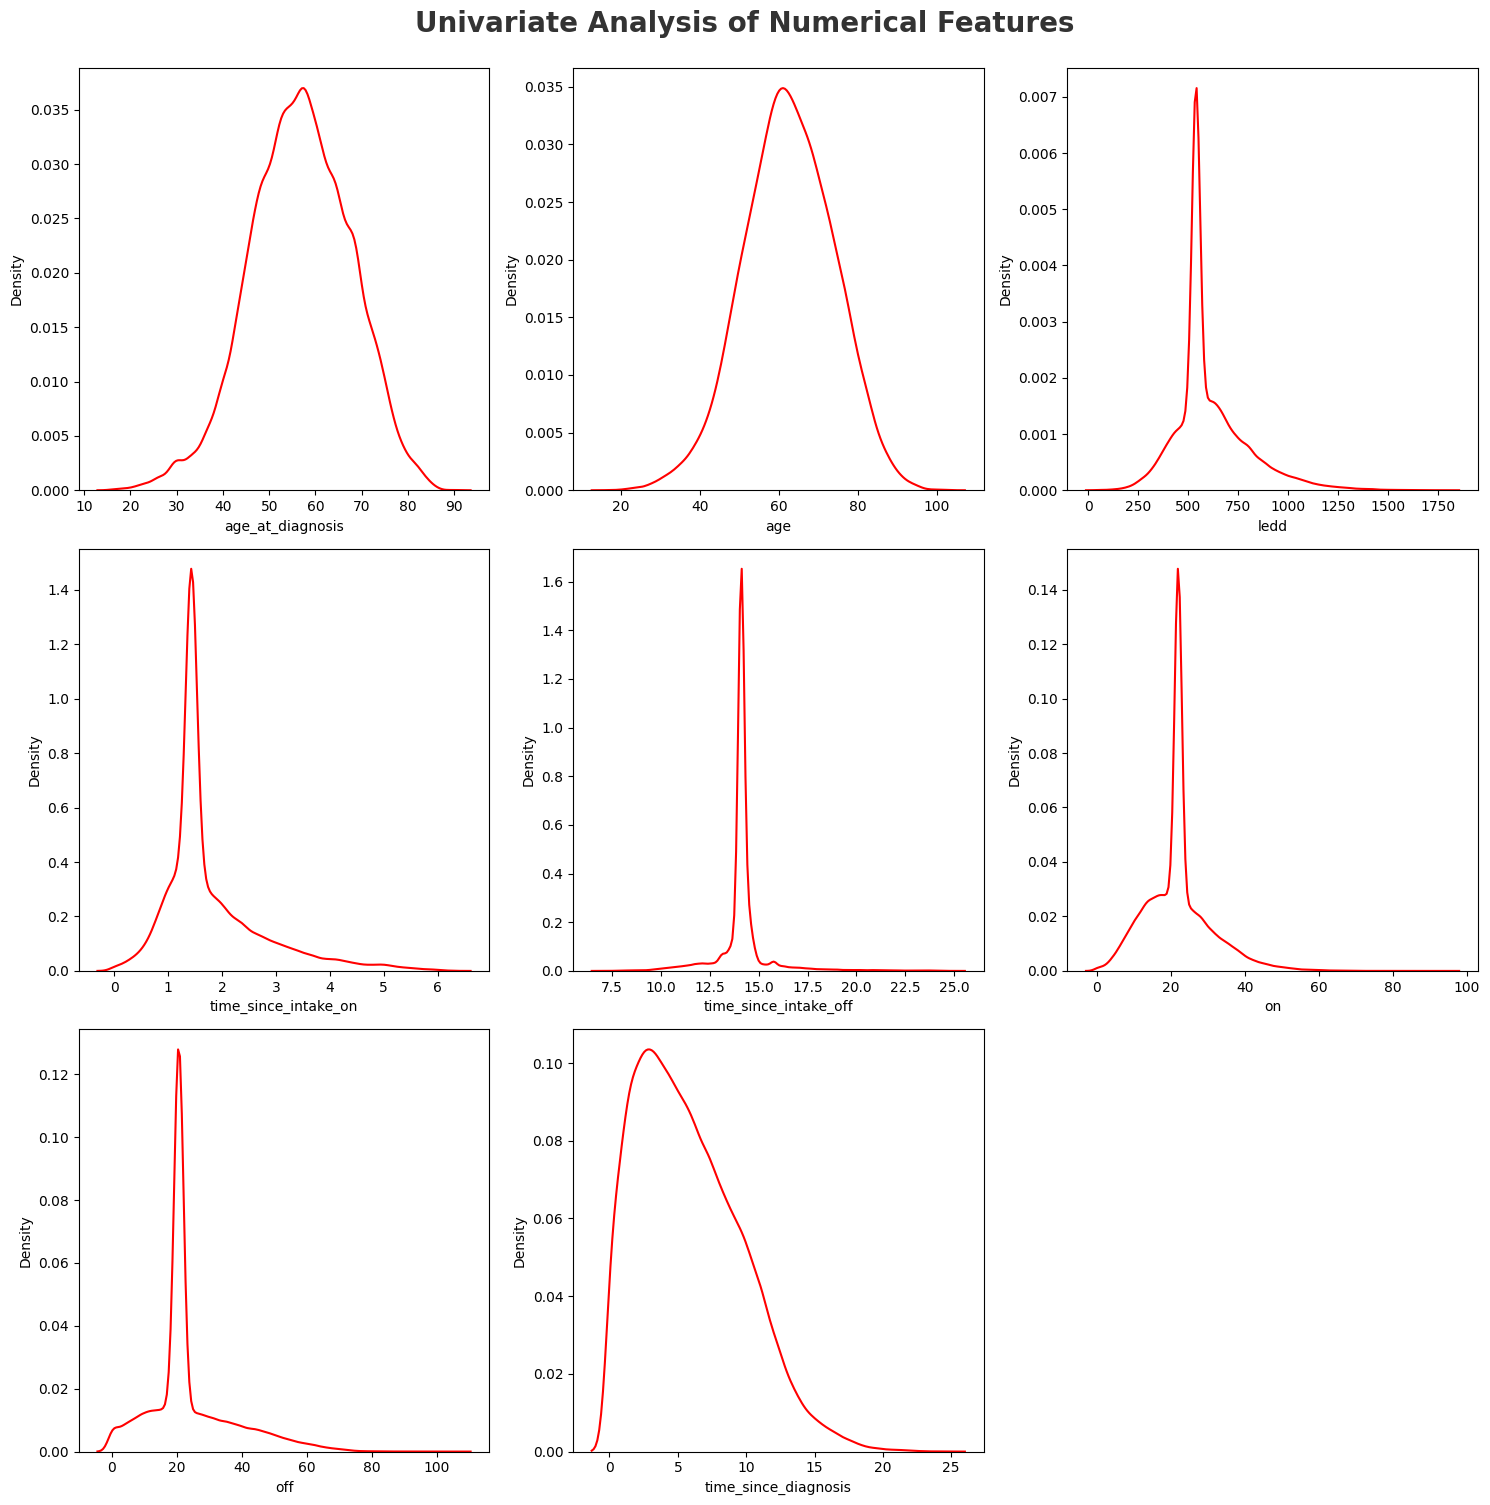

In [79]:
## Proportion of count data on numerical columns
plt.figure(figsize=(15, 15))
plt.suptitle('Univariate Analysis of Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

numerical_features = [item for item in numeric_features if item not in ['Index', 'sexM']]

for i in range(0, len(numerical_features)):
    
    plt.subplot(3, 3, i+1)
    sns.kdeplot(x=X_train_imputed[numerical_features[i]], color='r')
    plt.xlabel(numerical_features[i])
    plt.tight_layout()

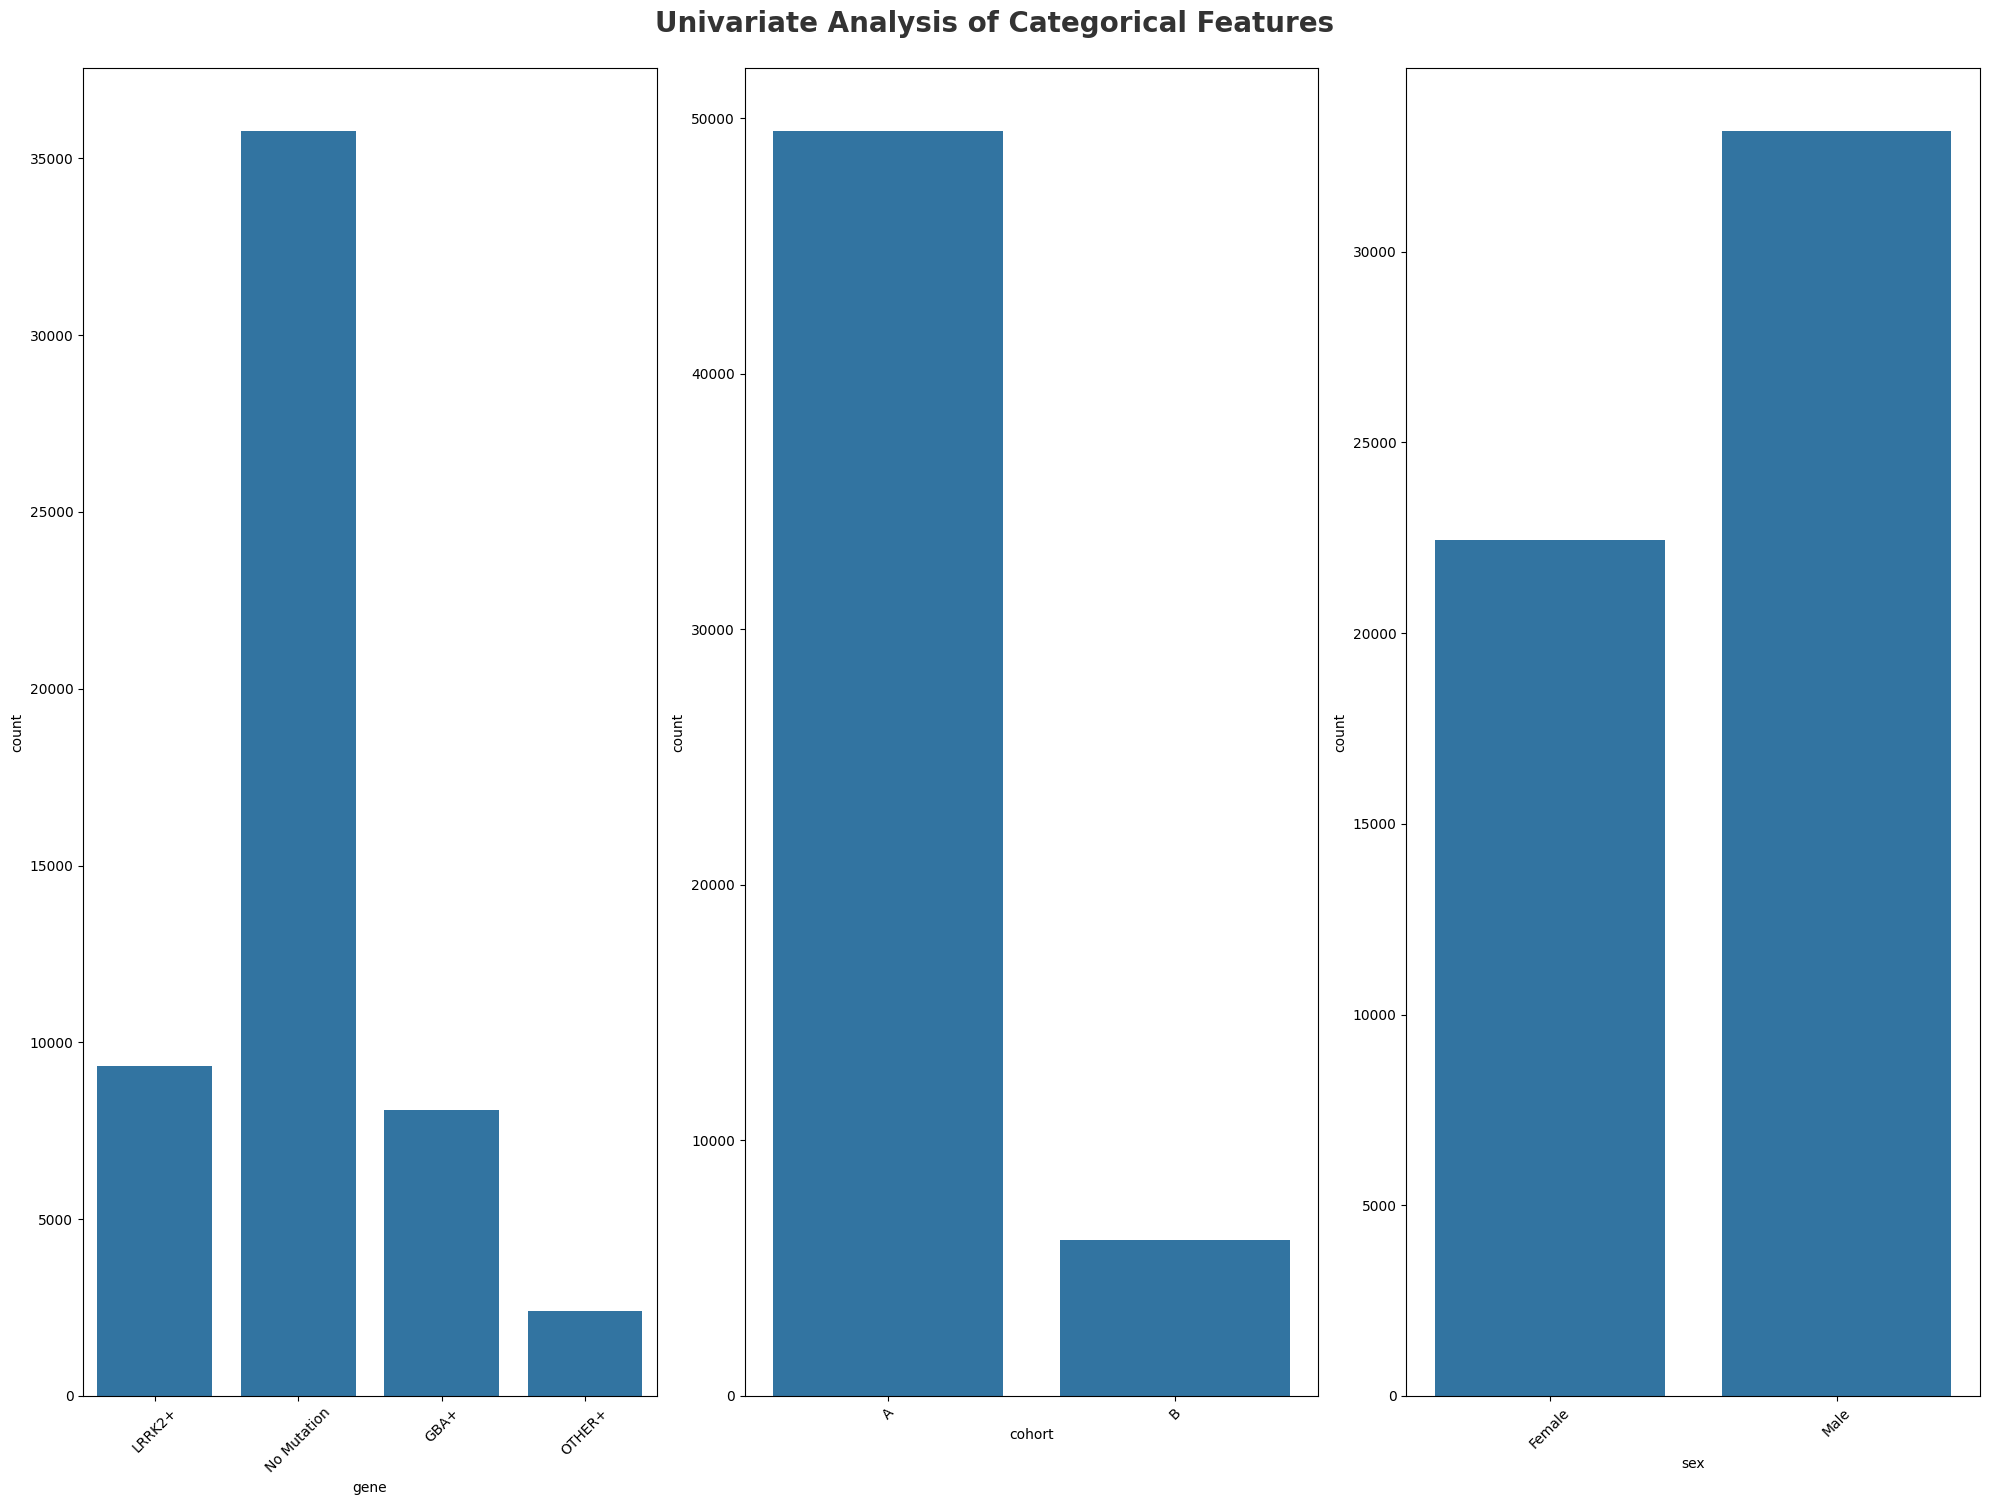

In [80]:
# categorical columns
plt.figure(figsize=(20, 15))
plt.suptitle('Univariate Analysis of Categorical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
categories = ['gene', 'cohort','sex']
for i in range(0, len(categories)):
    plt.subplot(1, 3, i+1)
    sns.countplot(x=X_train_imputed[categories[i]])
    plt.xlabel(categories[i])
    plt.xticks(rotation=45)
    plt.tight_layout() 

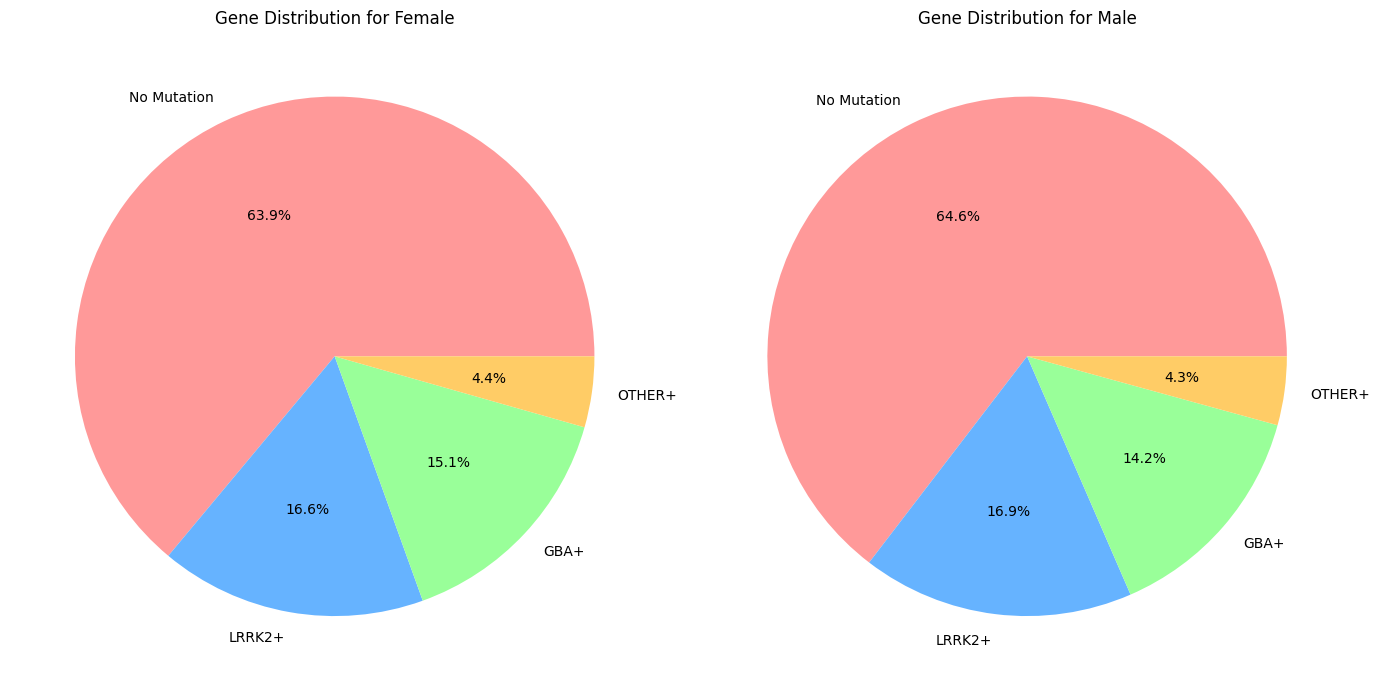

In [81]:
# Filter the data for females and males
X_train_female = X_train_imputed[X_train_imputed['sexM'] == 0]
X_train_male = X_train_imputed[X_train_imputed['sexM'] == 1]


# Create subplots for the pie charts
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot pie chart for females
female_gene_counts = X_train_female['gene'].value_counts()
axes[0].pie(female_gene_counts, labels=female_gene_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99', '#ffcc66'])
axes[0].set_title('Gene Distribution for Female')

# Plot pie chart for males
male_gene_counts = X_train_male['gene'].value_counts()
axes[1].pie(male_gene_counts, labels=male_gene_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99', '#ffcc66'])
axes[1].set_title('Gene Distribution for Male')

# Display the pie charts
plt.tight_layout()
plt.show()

# Feature Engineering for Parkinson's Disease OFF Score Prediction

After successfully imputing missing values in our dataset, we now proceed with feature engineering to create more informative predictors for our model. Our goal is to predict the true OFF scores for Parkinson's disease patients, which represent the unbiased motor function assessment.

## Feature Engineering Strategy

We've implemented a multi-stage feature engineering approach focused on creating clinically relevant features:

```python
def simple_feature_engineering(X_train, X_test):
    """
    Simplified feature engineering for Parkinson's Disease data
    focusing on predicting true OFF scores
    """
    X_train_fe = X_train.copy()
    X_test_fe = X_test.copy()
    
    # Feature engineering steps...
    
    return X_train_fe_final, X_test_fe_final
```

### 1. Disease Progression Features

```python
# Disease duration 
df['disease_duration'] = df['age'] - df['age_at_diagnosis']

# ON-OFF difference
df['on_off_diff'] = df['on'] - df['off']

# LEDD per year of disease
df['ledd_per_year'] = df['ledd'] / np.maximum(df['disease_duration'], 1)
```

These features capture important clinical aspects of Parkinson's disease:
- **Disease duration**: Represents progression time since diagnosis
- **ON-OFF difference**: Captures medication responsiveness
- **LEDD per year**: Normalizes medication dosage by disease duration

### 2. Medication Timing Features

```python
# Time ratios
df['time_ratio_on_off'] = df['time_since_intake_on'] / df['time_since_intake_off']

# Time categories (binned)
df['short_time_since_on'] = (df['time_since_intake_on'] < 1.0).astype(int)
df['medium_time_since_on'] = ((df['time_since_intake_on'] >= 1.0) & 
                              (df['time_since_intake_on'] < 3.0)).astype(int)
df['long_time_since_on'] = (df['time_since_intake_on'] >= 3.0).astype(int)
```

These features help account for medication timing effects:
- **Time ratio**: Relationship between ON and OFF assessment timing
- **Time categories**: Different phases of medication response (early, optimal, wearing-off)

### 3. Interaction Features

```python
# Age-LEDD interaction
df['age_ledd_interaction'] = df['age'] * df['ledd']

# Time-LEDD interaction
df['time_on_ledd_interaction'] = df['time_since_intake_on'] * df['ledd']

# Disease duration - ON score interaction
df['duration_on_interaction'] = df['disease_duration'] * df['on']
```

These interaction terms capture important combined effects:
- **Age-LEDD**: How medication effect varies with age
- **Time-LEDD**: How timing and dosage interact
- **Duration-ON**: How disease progression affects ON state scores

### 4. Categorical Feature Encoding

We one-hot encoded categorical features:
- **Gene variants**: Converted to binary indicators
- **Cohort information**: Encoded to capture study-specific effects

## Feature Selection

After engineering, we applied feature selection to identify the most predictive variables:

```python
def select_best_features(X_train, X_test, y_train, method='mutual_info', k=20):
    # Feature selection implementation...
    return X_train_selected, X_test_selected, selected_features
```

1. **Standardization**: We scaled all features to ensure fair comparison
2. **Selection Method**: Used mutual information regression to identify nonlinear relationships
3. **Top Features**: Selected the 20 most informative features

## Results

Our feature engineering process significantly expanded the feature set with clinically relevant predictors:

```
Original feature count: 13
After engineering: 24
After selection: 20
```

The selected features represent the most important predictors for OFF score estimation, capturing disease progression, medication response, and timing effects.

## Next Steps

With our engineered and selected features, we can now proceed to:
1. Train predictive models
2. Evaluate performance
3. Fine-tune model parameters

Our feature engineering approach is grounded in clinical understanding of Parkinson's disease, focusing on the relationship between medication timing, disease progression, and motor function.

In [90]:
# Simplified Feature Engineering for Parkinson's Disease OFF Score Prediction
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

y_train.drop(columns=['Index'],axis=1,inplace=True)

def simple_feature_engineering(X_train, X_test):
    """
    Simplified feature engineering for Parkinson's Disease data
    focusing on predicting true OFF scores
    """
    # Create copies to avoid modifying originals
    X_train_fe = X_train.copy()
    X_test_fe = X_test.copy()
    
    # --- 1. Basic Disease Features ---
    
    for df in [X_train_fe, X_test_fe]:
        # Disease duration 
        df['disease_duration'] = df['age'] - df['age_at_diagnosis']
        
        # ON-OFF difference (if both exist)
        df['on_off_diff'] = df['on'] - df['off']
        
        # LEDD per year of disease
        df['ledd_per_year'] = df['ledd'] / np.maximum(df['disease_duration'], 1)
        
    # --- 2. Simple Time Features ---
    
    for df in [X_train_fe, X_test_fe]:
        # Time ratios
        df['time_ratio_on_off'] = df['time_since_intake_on'] / df['time_since_intake_off']
        
        # Time categories (binned)
        df['short_time_since_on'] = (df['time_since_intake_on'] < 1.0).astype(int)
        df['medium_time_since_on'] = ((df['time_since_intake_on'] >= 1.0) & 
                                      (df['time_since_intake_on'] < 3.0)).astype(int)
        df['long_time_since_on'] = (df['time_since_intake_on'] >= 3.0).astype(int)
    
    # --- 3. Simple Interaction Terms ---
    
    for df in [X_train_fe, X_test_fe]:
        # Age-LEDD interaction
        df['age_ledd_interaction'] = df['age'] * df['ledd']
        
        # Time-LEDD interaction
        df['time_on_ledd_interaction'] = df['time_since_intake_on'] * df['ledd']
        
        # Disease duration - ON score interaction
        df['duration_on_interaction'] = df['disease_duration'] * df['on']
    
    # --- 4. One-hot encode categorical features ---
    
    # Convert gene to categorical if it's not already
    if 'gene' in X_train_fe.columns:
        gene_dummies_train = pd.get_dummies(X_train_fe['gene'], prefix='gene', drop_first=True)
        gene_dummies_test = pd.get_dummies(X_test_fe['gene'], prefix='gene', drop_first=True)
        
        # Ensure same columns in both sets
        for col in gene_dummies_train.columns:
            if col not in gene_dummies_test.columns:
                gene_dummies_test[col] = 0
        for col in gene_dummies_test.columns:
            if col not in gene_dummies_train.columns:
                gene_dummies_train[col] = 0
                
        # Add to dataframes
        X_train_fe = pd.concat([X_train_fe, gene_dummies_train], axis=1)
        X_test_fe = pd.concat([X_test_fe, gene_dummies_test], axis=1)
    
    # Also one-hot encode cohort if it exists
    if 'cohort' in X_train_fe.columns:
        cohort_dummies_train = pd.get_dummies(X_train_fe['cohort'], prefix='cohort', drop_first=True)
        cohort_dummies_test = pd.get_dummies(X_test_fe['cohort'], prefix='cohort', drop_first=True)
        
        # Ensure same columns
        for col in cohort_dummies_train.columns:
            if col not in cohort_dummies_test.columns:
                cohort_dummies_test[col] = 0
        for col in cohort_dummies_test.columns:
            if col not in cohort_dummies_train.columns:
                cohort_dummies_train[col] = 0
                
        # Add to dataframes
        X_train_fe = pd.concat([X_train_fe, cohort_dummies_train], axis=1)
        X_test_fe = pd.concat([X_test_fe, cohort_dummies_test], axis=1)
    
    # --- 5. Drop unnecessary columns ---
    
    # Columns to drop (IDs and original categorical columns now encoded)
    cols_to_drop = ['patient_id', 'gene', 'cohort', 'index']
    
    # Only drop columns that exist
    X_train_fe_final = X_train_fe.drop([c for c in cols_to_drop if c in X_train_fe.columns], axis=1)
    X_test_fe_final = X_test_fe.drop([c for c in cols_to_drop if c in X_test_fe.columns], axis=1)
    
    return X_train_fe_final, X_test_fe_final


def select_best_features(X_train, X_test, y_train, method='mutual_info', k=20):
    """
    Select the most important features using different methods
    
    Parameters:
    - X_train, X_test: Feature matrices
    - y_train: Target values for training data
    - method: 'f_regression' or 'mutual_info'
    - k: Number of features to select
    
    Returns:
    - X_train_selected, X_test_selected: Datasets with selected features
    - selected_features: List of selected feature names
    """
    # Choose selection method
    if method == 'f_regression':
        selector = SelectKBest(f_regression, k=k)
    else:  # default to mutual_info
        selector = SelectKBest(mutual_info_regression, k=k)
    
    # Fit on training data
    selector.fit(X_train, y_train)
    
    # Get selected feature indices and names
    selected_indices = selector.get_support(indices=True)
    selected_features = X_train.columns[selected_indices].tolist()
    
    # Select features
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    
    # Print selected features and their scores
    scores = selector.scores_
    feature_scores = list(zip(X_train.columns, scores))
    feature_scores.sort(key=lambda x: x[1], reverse=True)
    
    print(f"Top {k} features selected using {method}:")
    for feature, score in feature_scores[:k]:
        print(f"{feature}: {score:.4f}")
    
    return X_train_selected, X_test_selected, selected_features


# Apply feature engineering
X_train_engineered, X_test_engineered = simple_feature_engineering(X_train_imputed, X_test_imputed)

# Scale features before selection
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_engineered),
    columns=X_train_engineered.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_engineered),
    columns=X_test_engineered.columns
)

# Select best features 
X_train_selected, X_test_selected, selected_features = select_best_features(
    X_train_scaled, X_test_scaled, y_train, 
    method='mutual_info', 
    k=20
)

print(f"\nOriginal feature count: {X_train_imputed.shape[1]}")
print(f"After engineering: {X_train_engineered.shape[1]}")
print(f"After selection: {X_train_selected.shape[1]}")

C:\Users\cilek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Top 20 features selected using mutual_info:
on_off_diff: 0.7315
off: 0.6498
on: 0.4950
time_since_intake_off: 0.4800
time_ratio_on_off: 0.4685
ledd: 0.3347
duration_on_interaction: 0.3015
time_on_ledd_interaction: 0.3011
time_since_intake_on: 0.3008
disease_duration: 0.1839
time_since_diagnosis: 0.1835
ledd_per_year: 0.1626
age_ledd_interaction: 0.1330
medium_time_since_on: 0.0501
age: 0.0470
short_time_since_on: 0.0255
long_time_since_on: 0.0164
age_at_diagnosis: 0.0105
cohort_B: 0.0078
gene_No Mutation: 0.0056

Original feature count: 13
After engineering: 24
After selection: 20


In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_target = y_train.iloc[:, 0] if isinstance(y_train, pd.DataFrame) else y_train[:, 0]
else:
    y_target = y_train

# Create analysis dataset with features and target
analysis_df = X_train_engineered.copy()
analysis_df['off_score'] = y_target

## Correlation Heatmap

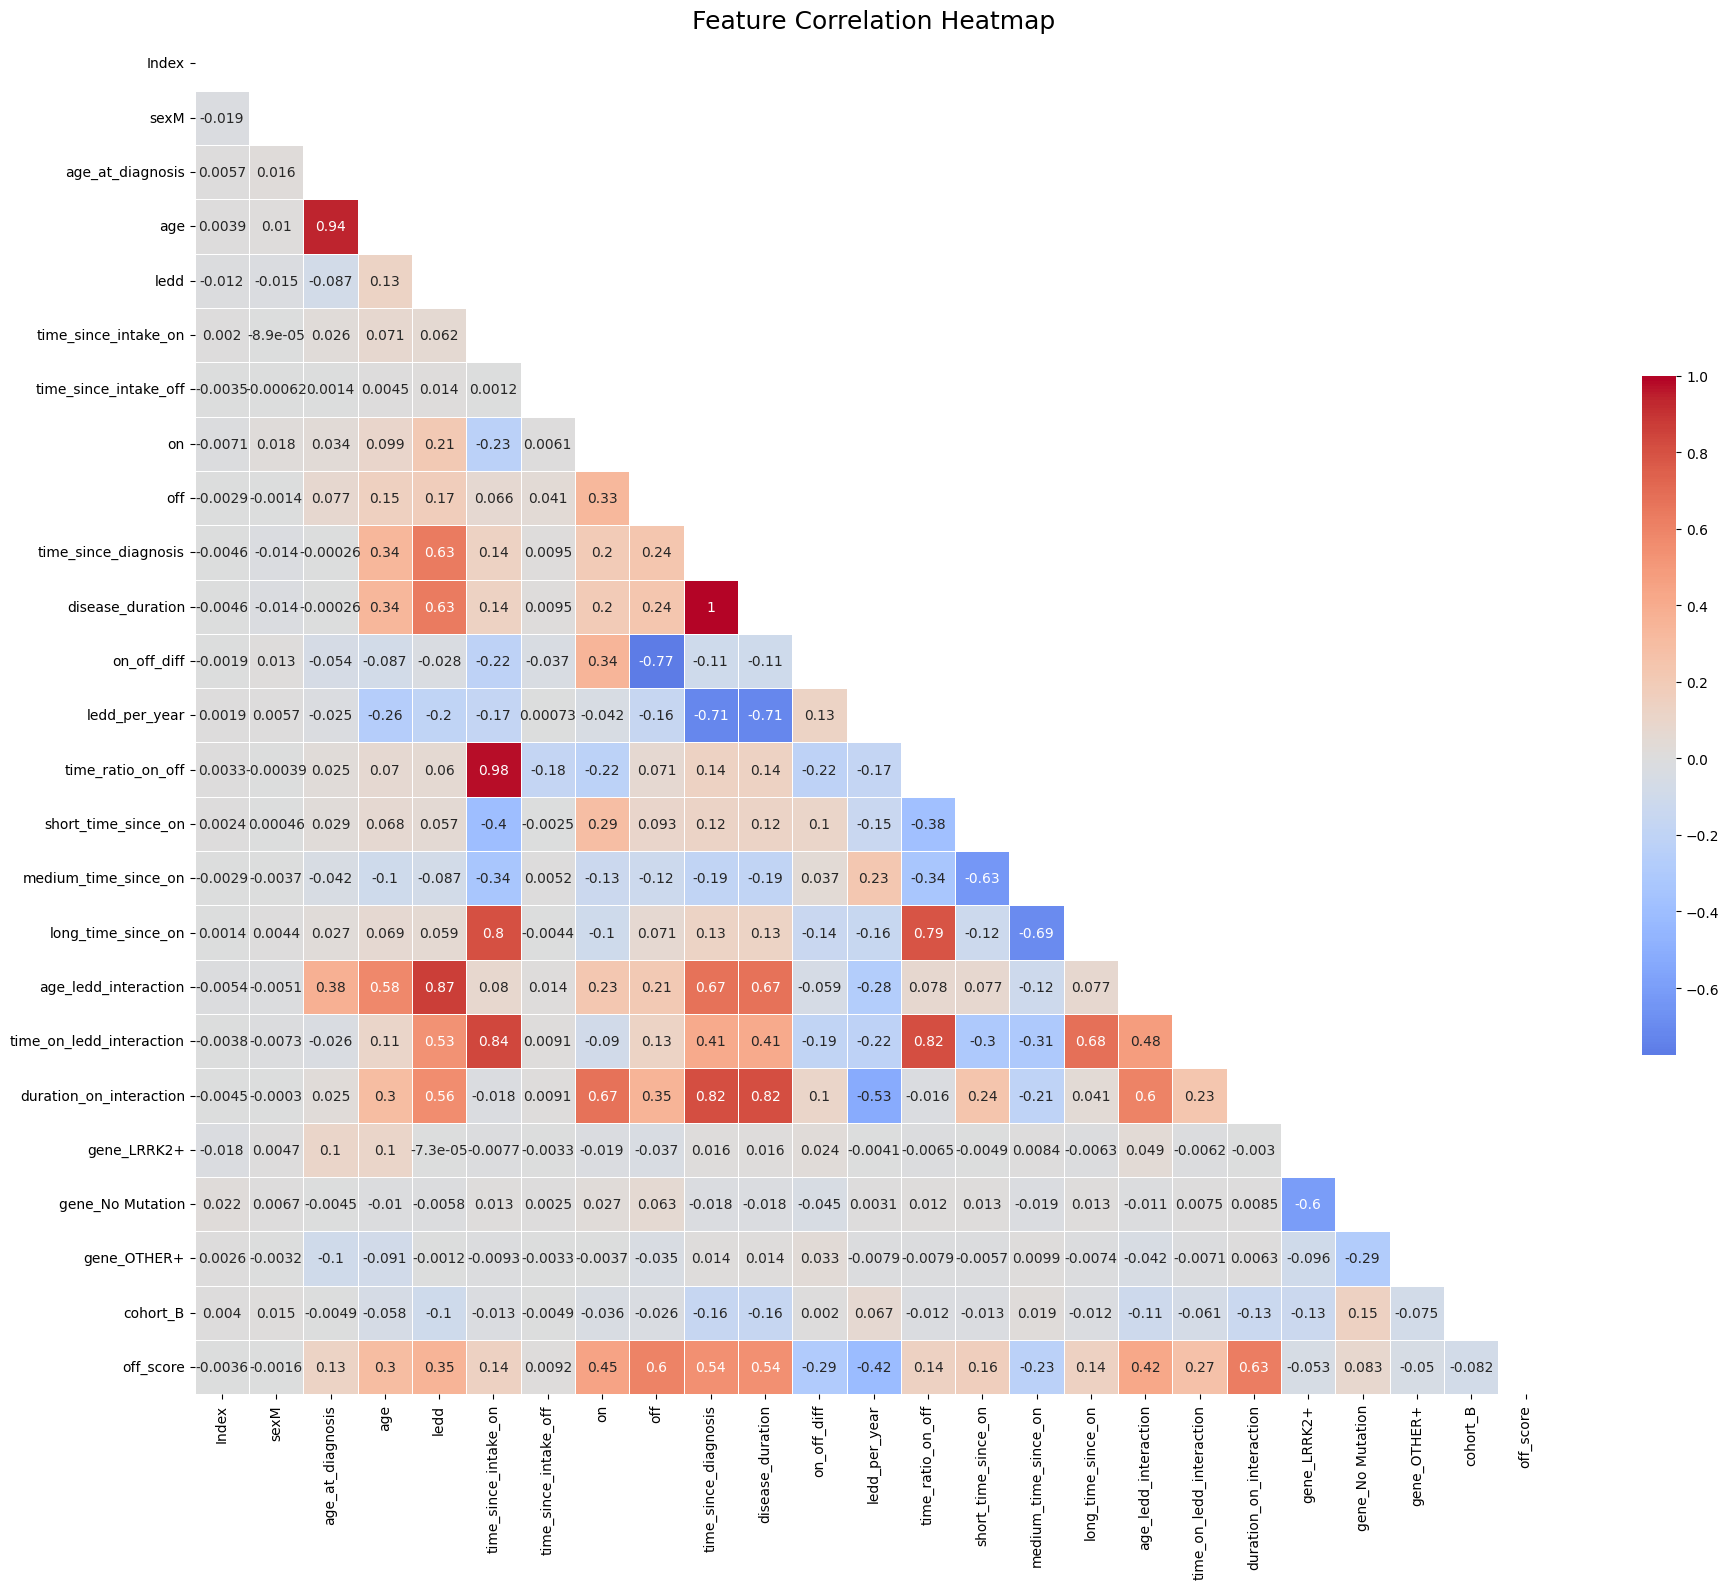

In [97]:
# 1. Feature Correlation Analysis
plt.figure(figsize=(20, 16))
corr = analysis_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, annot=True, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Feature Correlation Heatmap', fontsize=18)
plt.tight_layout()
plt.show()

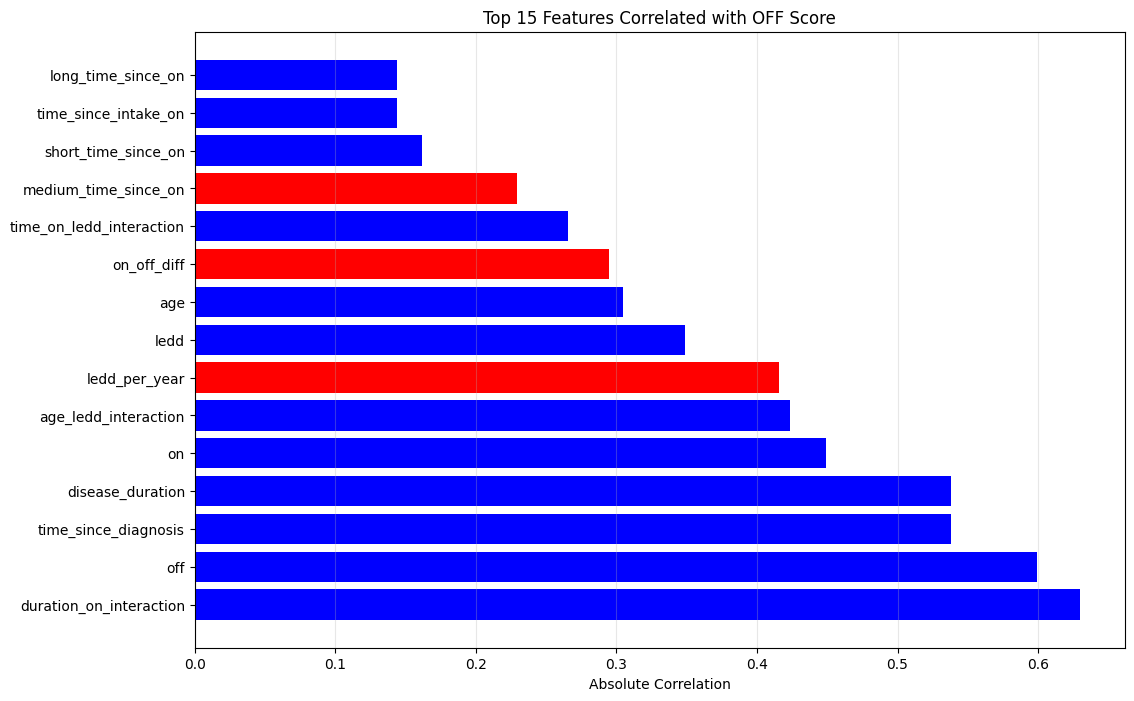

In [99]:
# 2. Top Feature Correlations with Target
target_corrs = []
for col in analysis_df.columns:
    if col == 'off_score':
        continue
    corr, p = pearsonr(analysis_df[col], analysis_df['off_score'])
    target_corrs.append((col, corr, p))

target_corrs.sort(key=lambda x: abs(x[1]), reverse=True)
top_feats = [x[0] for x in target_corrs[:10]]


# Plot correlations with target
plt.figure(figsize=(12, 8))
corr_vals = [x[1] for x in target_corrs[:15]]
feat_names = [x[0] for x in target_corrs[:15]]
colors = ['blue' if c > 0 else 'red' for c in corr_vals]
plt.barh(range(len(feat_names)), [abs(c) for c in corr_vals], color=colors)
plt.yticks(range(len(feat_names)), feat_names)
plt.xlabel('Absolute Correlation')
plt.title('Top 15 Features Correlated with OFF Score')
plt.grid(axis='x', alpha=0.3)
plt.show()


<Figure size 1600x1400 with 0 Axes>

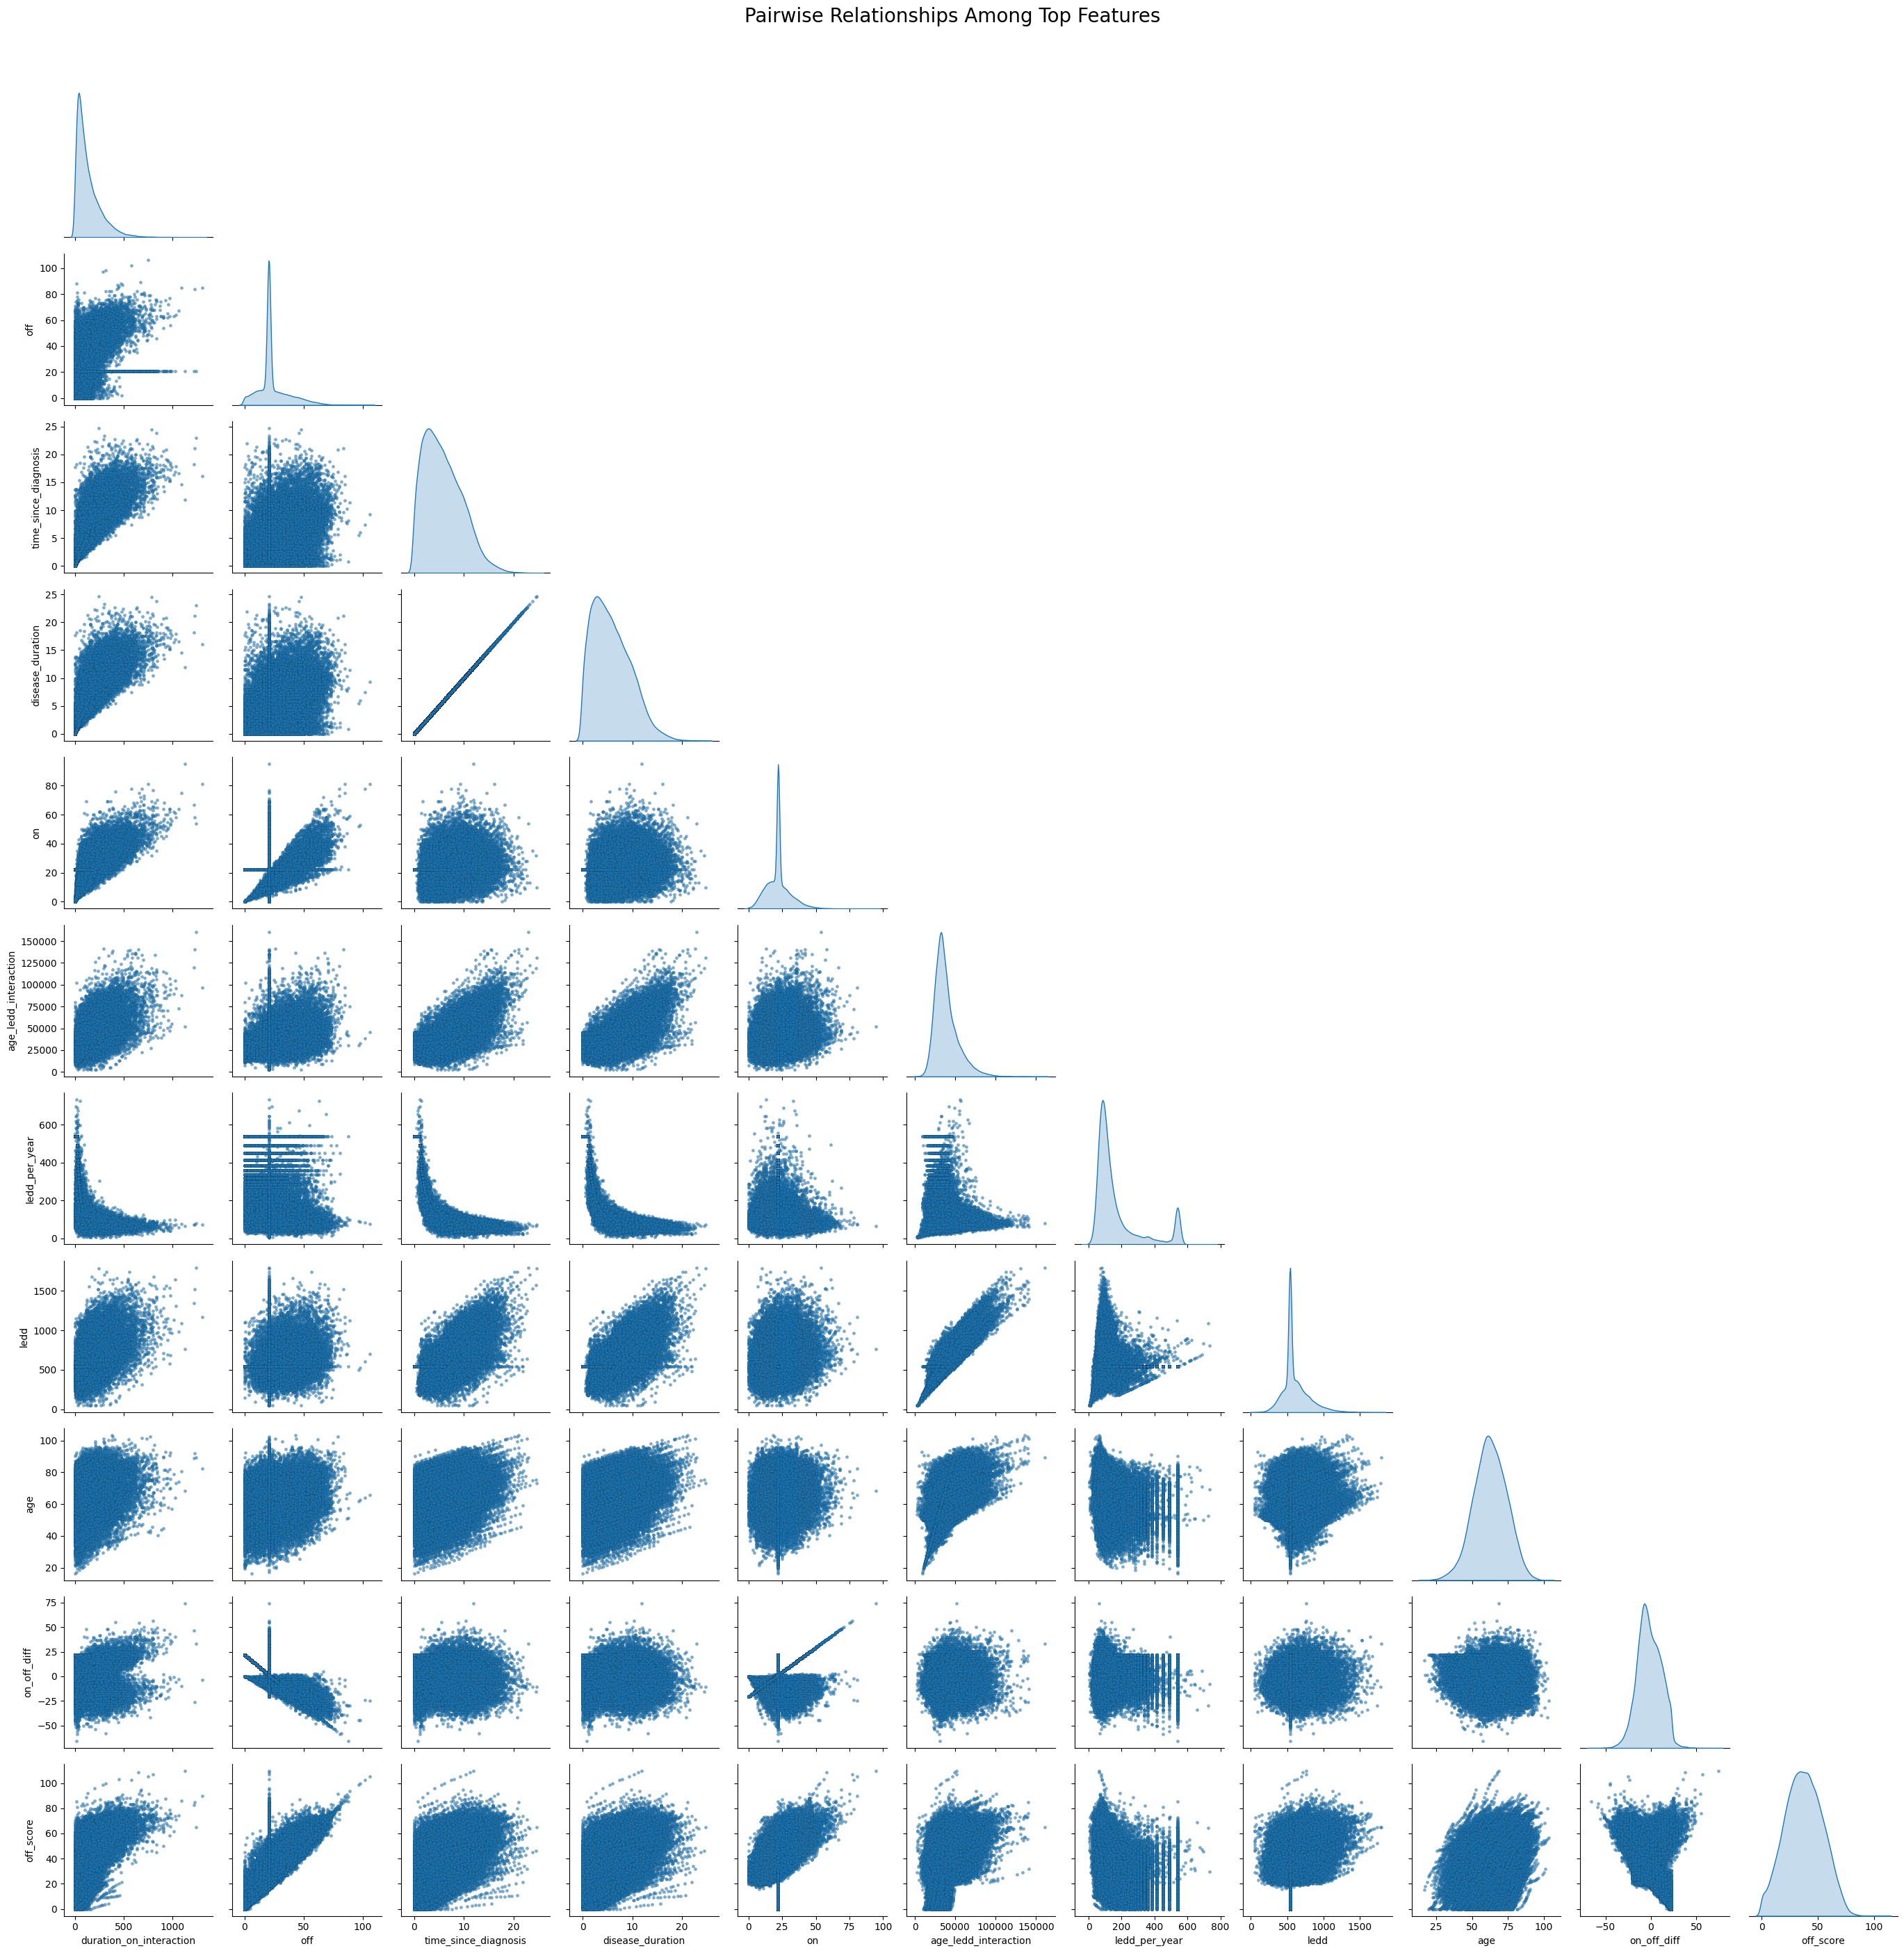

In [100]:
# 3. Pairplot of top features
plt.figure(figsize=(16, 14))
top_feats_df = analysis_df[top_feats + ['off_score']].copy()
sns.pairplot(top_feats_df, corner=True, diag_kind='kde', 
             plot_kws={'alpha': 0.6, 's': 10, 'edgecolor': 'k', 'linewidth': 0.1})
plt.suptitle('Pairwise Relationships Among Top Features', y=1.02, fontsize=20)
plt.tight_layout()
plt.show()

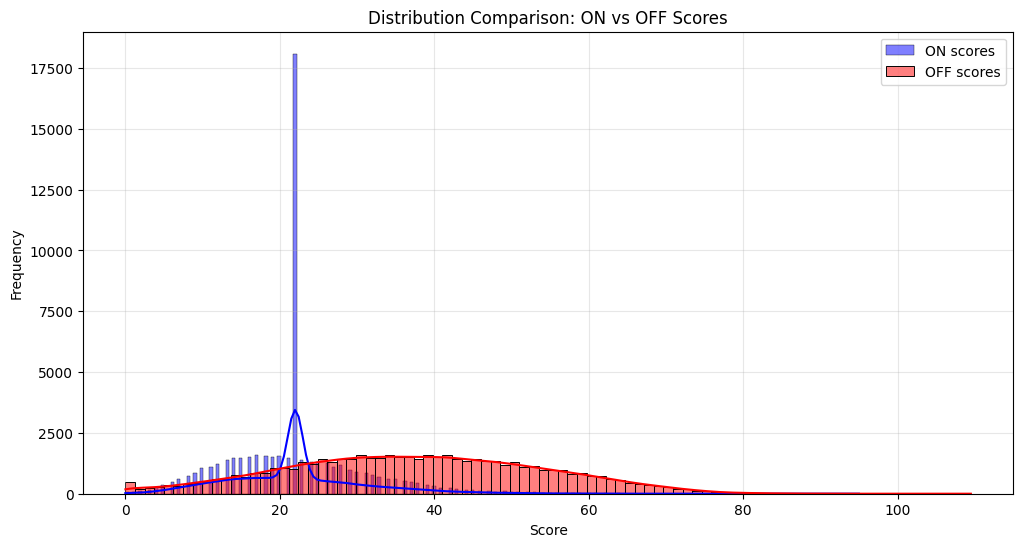

In [101]:
# 4. Distribution of ON vs OFF scores
if 'on' in analysis_df.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(analysis_df['on'], color='blue', label='ON scores', kde=True, alpha=0.5)
    sns.histplot(analysis_df['off_score'], color='red', label='OFF scores', kde=True, alpha=0.5)
    plt.legend()
    plt.title('Distribution Comparison: ON vs OFF Scores')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.show()

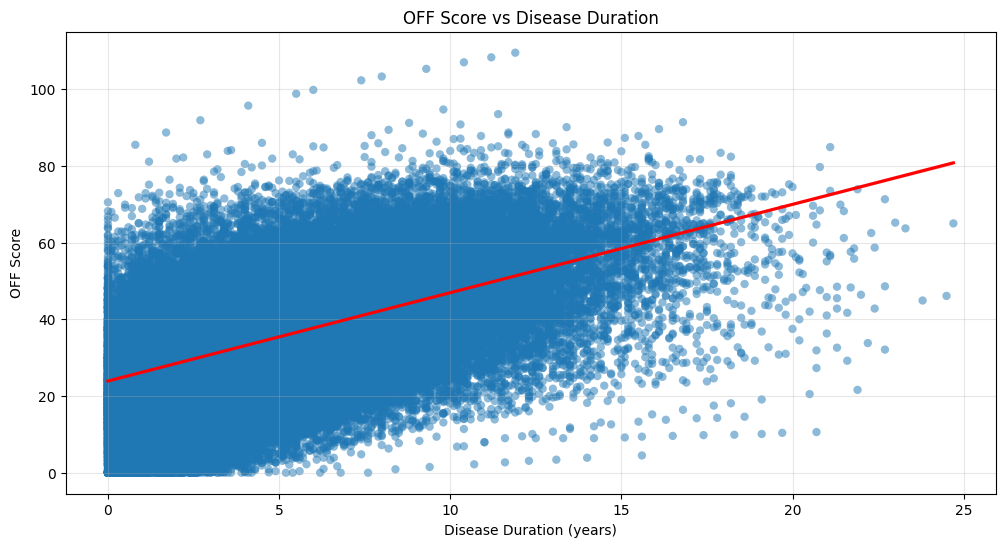

In [102]:
# 5. OFF score by disease duration
if 'disease_duration' in analysis_df.columns:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='disease_duration', y='off_score', data=analysis_df, 
                    alpha=0.5, edgecolor='none')
    sns.regplot(x='disease_duration', y='off_score', data=analysis_df, 
                scatter=False, color='red')
    plt.title('OFF Score vs Disease Duration')
    plt.xlabel('Disease Duration (years)')
    plt.ylabel('OFF Score')
    plt.grid(alpha=0.3)
    plt.show()

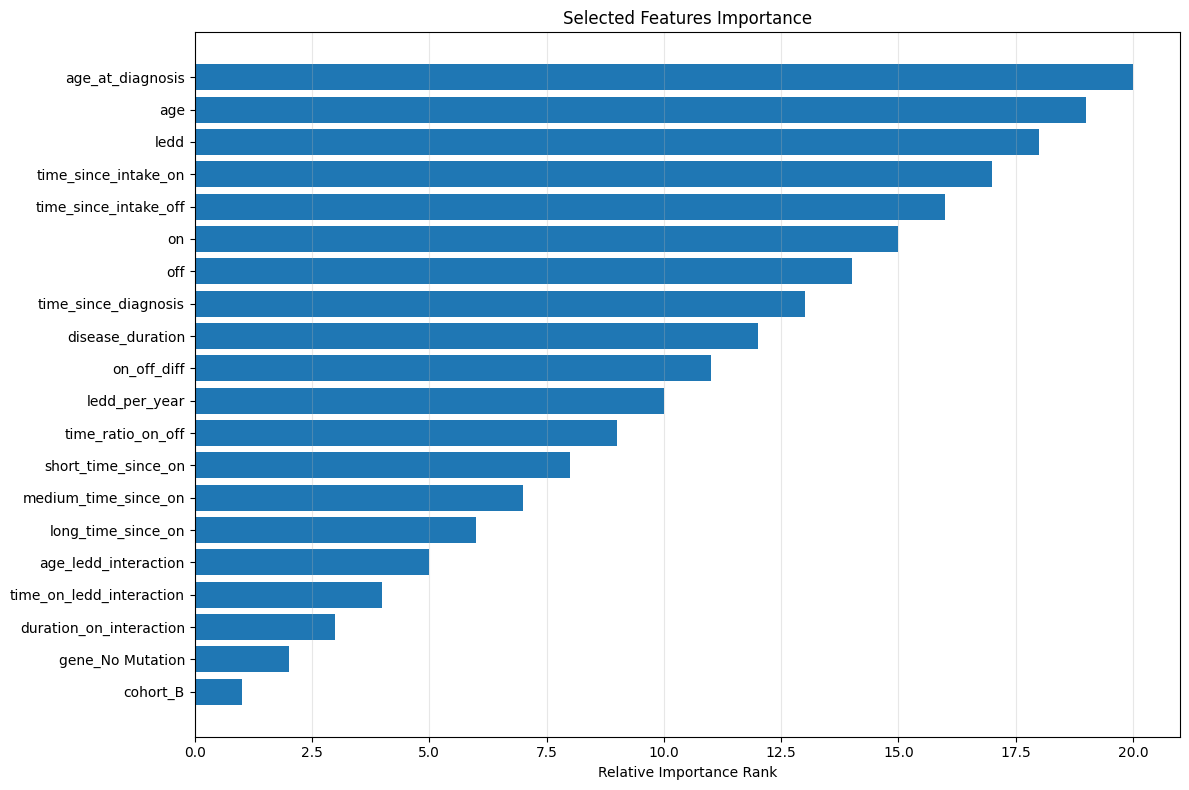

In [103]:
# 6. Feature Importance from Selected Features
if selected_features:
    plt.figure(figsize=(12, 8))
    importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': range(len(selected_features), 0, -1)
    })
    importance_df = importance_df.sort_values('Importance', ascending=True)
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Relative Importance Rank')
    plt.title('Selected Features Importance')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

## Principal Component Analysis

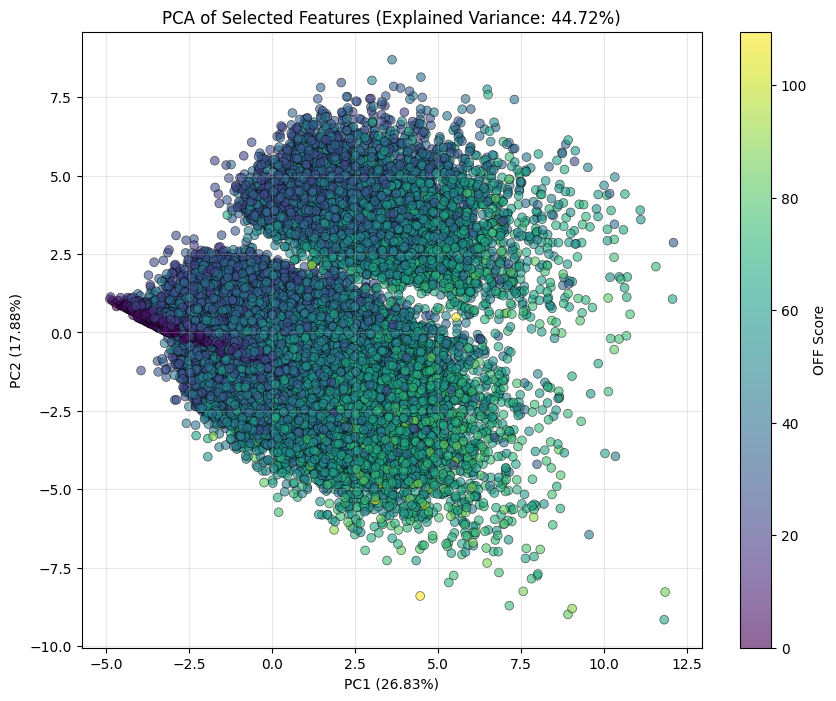

In [ ]:
# 7. PCA Analysis
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_train_selected)

# Convert y_target to 1D array
if isinstance(y_target, pd.DataFrame):
    y_values = y_target.values.ravel()  # Convert to 1D array
else:
    y_values = y_target

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y_values,
            cmap='viridis', alpha=0.6, edgecolor='k', s=40, linewidth=0.5)
plt.colorbar(label='OFF Score')
plt.title(f'PCA of Selected Features (Explained Variance: {pca.explained_variance_ratio_.sum():.2%})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.grid(alpha=0.3)
plt.show()

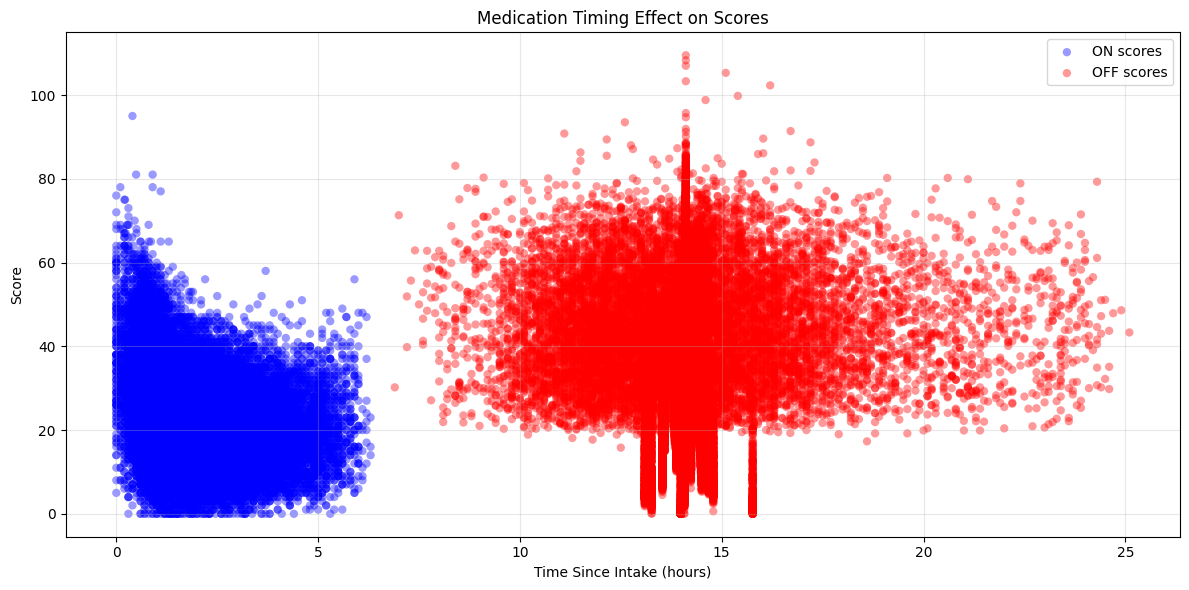

In [105]:
# 8. Visualize relationship between time since medication and scores
if 'time_since_intake_on' in analysis_df.columns and 'on' in analysis_df.columns:
    plt.figure(figsize=(12, 6))
    plt.scatter(analysis_df['time_since_intake_on'], analysis_df['on'], 
                alpha=0.4, label='ON scores', color='blue', edgecolor='none')
    plt.scatter(analysis_df['time_since_intake_off'], analysis_df['off_score'], 
                alpha=0.4, label='OFF scores', color='red', edgecolor='none')
    plt.legend()
    plt.title('Medication Timing Effect on Scores')
    plt.xlabel('Time Since Intake (hours)')
    plt.ylabel('Score')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

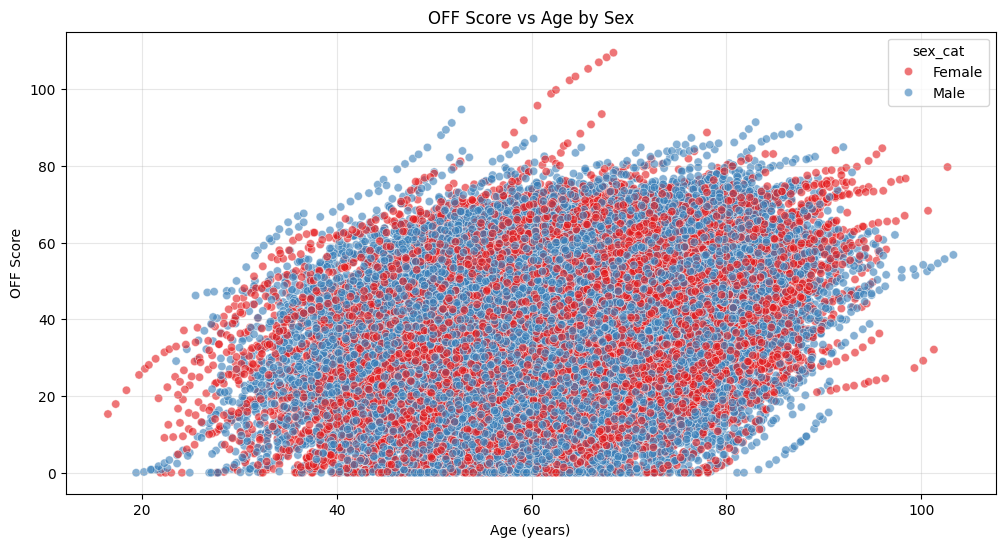

In [106]:
# 9. Age vs OFF Score by Sex
if 'age' in analysis_df.columns and 'sexM' in analysis_df.columns:
    plt.figure(figsize=(12, 6))
    # Convert sexM to categorical
    analysis_df['sex_cat'] = analysis_df['sexM'].map({1: 'Male', 0: 'Female'})
    sns.scatterplot(x='age', y='off_score', hue='sex_cat', data=analysis_df, 
                    alpha=0.6, palette='Set1')
    plt.title('OFF Score vs Age by Sex')
    plt.xlabel('Age (years)')
    plt.ylabel('OFF Score')
    plt.grid(alpha=0.3)
    plt.show()

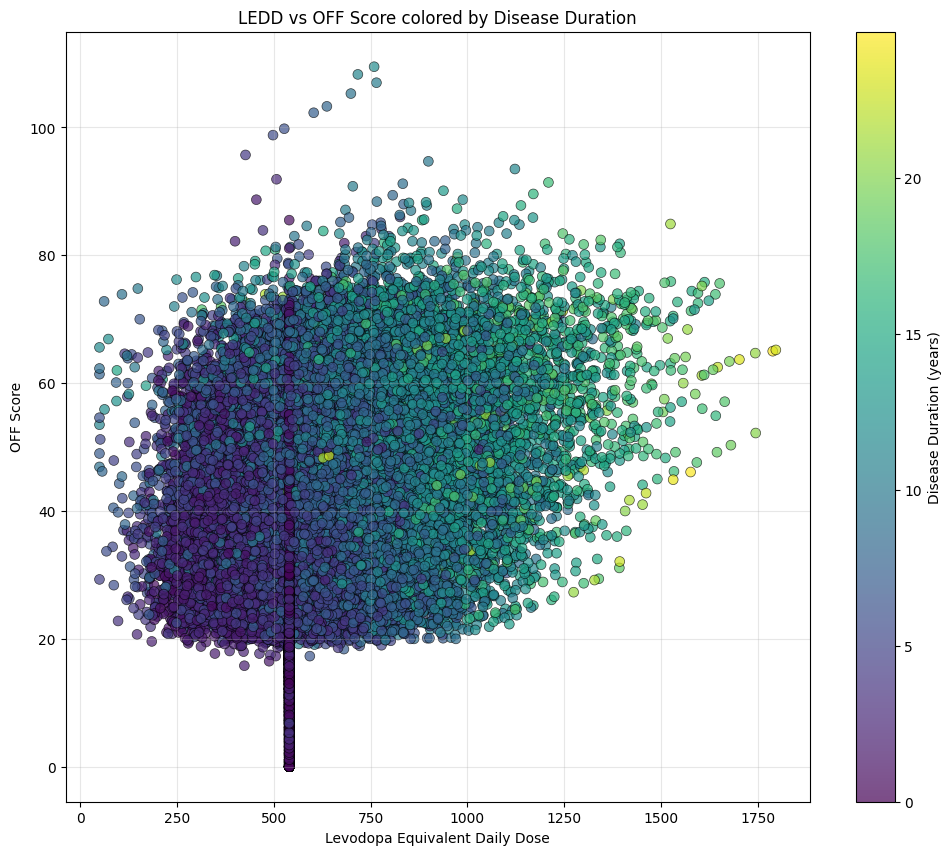

In [107]:
# 10. LEDD vs OFF Score with Disease Duration
if all(col in analysis_df.columns for col in ['ledd', 'disease_duration']):
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(analysis_df['ledd'], analysis_df['off_score'], 
               c=analysis_df['disease_duration'], cmap='viridis', 
               alpha=0.7, edgecolor='k', s=50, linewidth=0.5)
    plt.colorbar(scatter, label='Disease Duration (years)')
    plt.title('LEDD vs OFF Score colored by Disease Duration')
    plt.xlabel('Levodopa Equivalent Daily Dose')
    plt.ylabel('OFF Score')
    plt.grid(alpha=0.3)
    plt.show()

## Saving Train and Test files in csv

In [120]:
# Get the selected features but unscaled
X_train_selected_unscaled = X_train_engineered[selected_features].copy()
X_test_selected_unscaled = X_test_engineered[selected_features].copy()

# Save unscaled selected features to CSV
X_train_selected_unscaled.to_csv('..\\data\\X_train.csv', index=False)
X_test_selected_unscaled.to_csv('..\\data\\X_test.csv', index=False)

print("Unscaled selected features datasets saved successfully!")
print(f"X_train_selected_unscaled shape: {X_train_selected_unscaled.shape}")
print(f"X_test_selected_unscaled shape: {X_test_selected_unscaled.shape}")

Unscaled selected features datasets saved successfully!
X_train_selected_unscaled shape: (55603, 20)
X_test_selected_unscaled shape: (23672, 20)
